In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, BatchNormalization

from google.colab import drive
import sys
from decimal import *
import math
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error, max_error , r2_score

from keras.callbacks import ModelCheckpoint
import seaborn as sns

# Conectamos con nuestro Google Drive

drive.mount('/content/drive', force_remount=True)
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
BASE_FOLDER = "/content/drive/MyDrive/Colab Notebooks/FinMaster/"
# agregamos a las paths del sistema la del colab
sys.path.append(BASE_FOLDER)

Mounted at /content/drive


# Cargar Datos

In [ ]:
def Cargar_datos(Tipo):
  ruta_users = os.path.join(BASE_FOLDER, "df_train_final.csv")
  df_train = pd.read_csv(ruta_users, sep=',',  engine='python')
  ruta_users = os.path.join(BASE_FOLDER, "df_val_final.csv")
  df_val = pd.read_csv(ruta_users, sep=',', engine='python')
  ruta_users = os.path.join(BASE_FOLDER, "df_test_final.csv")
  df_test = pd.read_csv(ruta_users, sep=',',  engine='python')

  if Tipo == 'RN':
    ruta_users = os.path.join(BASE_FOLDER, "df_y_train.csv")
    #df_y_train = pd.read_csv(ruta_users, sep=',',  engine='python')
    df_y_train = pd.DataFrame(df_train.iloc[:, 9:10])
    df_train.drop(['Precio'], axis=1,  inplace=True)
    ruta_users = os.path.join(BASE_FOLDER, "df_y_val.csv")
    #df_y_val = pd.read_csv(ruta_users, sep=',',  engine='python')
    df_y_val = pd.DataFrame(df_val.iloc[:, 9:10])
    df_val.drop(['Precio'],  axis=1, inplace=True)
    ruta_users = os.path.join(BASE_FOLDER, "df_y_test.csv")
    df_y_test = pd.DataFrame(df_test.iloc[:, 9:10])
    #df_y_test = pd.read_csv(ruta_users, sep=',',  engine='python')
    df_test.drop(['Precio'], axis=1, inplace=True)

    print('Hay ' + str(df_train.shape)+  ' datos de entrenamiento y ' + str(df_y_train.shape) + ' etiquetas' )
    print('Hay ' + str(df_val.shape)+  ' datos de validación y ' + str(df_y_val.shape) + ' etiquetas' )
    print('Hay ' + str(df_test.shape) +  ' datos de test y ' + str(df_y_test.shape) + ' etiquetas' )
    return df_train, df_val, df_test, df_y_train, df_y_val, df_y_test
  else:
    print('Hay ' + str(df_train.shape)+  ' datos de entrenamiento' )
    print('Hay ' + str(df_val.shape)+  ' datos de validación' )
    print('Hay ' + str(df_test.shape) +  ' datos de test' )
    return df_train, df_val, df_test

In [ ]:
def evaluate_predictions(predicted, actual):
    MAE = []
    MSE = []
    nb_samples, nb_series = actual.shape
    abs_errors = {}
    squared_errors = {}
    MAE = {}
    MSE = {}
    for j in range(nb_series):
        abs_errors[j] = []
        squared_errors[j] = []
    for i in range(nb_samples):
        for j in range(nb_series):
            abs_errors[j].append(abs(predicted[i][j] - actual[i][j]))  
            squared_errors[j].append((predicted[i][j] - actual[i][j])* (predicted[i][j] - actual[i][j]))          
    for j in range(nb_series):
        MAE[j] = (np.mean(np.asarray(abs_errors[j])))
        MSE[j] = (np.mean(np.asarray(squared_errors[j])))
    stats_res = {}
    stats_res["MAE"] = MAE
    stats_res["MSE"] = MSE
    stats_res["ABS_ERRORS"] = abs_errors
    cumul_errors = [0] * len(stats_res["ABS_ERRORS"][0])
    for j in stats_res["ABS_ERRORS"].keys():
        for i in range(len(stats_res["ABS_ERRORS"][j])):
            cumul_errors[i] += stats_res["ABS_ERRORS"][j][i]
    stats_res["CUMUL_ABS_ERRORS"] = cumul_errors
    return stats_res

In [ ]:
dtrain, dval, dtest , dy_train, dy_val, dy_test=Cargar_datos('RN')
dtrain_AE, dval_AE, dtest_AE =Cargar_datos('AE')

Hay (1460, 75) datos de entrenamiento y (1460, 1) etiquetas
Hay (626, 75) datos de validación y (626, 1) etiquetas
Hay (532, 75) datos de test y (532, 1) etiquetas
Hay (1460, 76) datos de entrenamiento
Hay (626, 76) datos de validación
Hay (532, 76) datos de test


# Graficas

In [ ]:
def GraficasEntrenamiento(hist, Tipo, path):
    plt.style.use("ggplot")
    if Tipo=='loss':
      df = pd.DataFrame(hist.history[Tipo], columns=['Entrenamiento'])
      df["Validación"] = pd.DataFrame(hist.history['val_'+ Tipo ])
      axt = df["Entrenamiento"].plot( figsize=(10, 5));
      axv = df["Validación"].plot(style="g", figsize=(10, 5));
      axv.set_ylabel("Validación");
      axv.set_title("Función de Perdidas [MSE]");
      axt.set_xlabel('No. Epocas')
      axt.set_ylabel("Entrenamiento");
      axt.legend(loc='lower left')
      axv.legend(loc='upper right')
    else:
      df1 = pd.DataFrame(hist.history[Tipo], columns=['Entrenamiento'])
      df1["Validación"] = pd.DataFrame(hist.history['val_'+Tipo])
      axt1 = df1["Entrenamiento"].plot( figsize=(10, 5));
      axv1 = df1["Validación"].plot( secondary_y=True, style="c", figsize=(10, 5));
      axv1.set_ylabel("Validación");
      axv1.set_title("Mean Absolute Percentage Error [MAPE]");
      axt1.set_xlabel('No. Epocas')
      axt1.set_ylabel("Entrenamiento");
      axt1.legend(loc='lower left')
      axv1.legend(loc='upper right')
    fig1 = plt.gcf()
    plt.savefig(path+"Entrenamiento_"+Tipo+".jpg", bbox_inches='tight')
    plt.show()

In [ ]:
def GraficasRealvsPredict(path, titulo, df_datos, r2,mse,  rmse ):
    sns.set_theme(style="darkgrid")
    plt.style.use("ggplot")
    g = sns.jointplot(x="Pronóstico", y="Reales", data=df_datos,   hue="Grupo" , xlim=[0, 1], ylim=[0,1], hue_order=['0','1','2','3','4','5','6','7','8','9','10'], height=8)
    g.set_axis_labels("Precio Pronóstico", "Precio Real")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Comparación del Precio Real Vs Pronóstico por Grupos de Localización\nDatos [ ' + titulo + ' ] \nR2 = [' + '{:5.4f}'.format(r2)+' ] MSE = [ ' + '{:5.4f}'.format(mse) + ' ] RMSE = [ ' + '{:5.4f}'.format(rmse) + ']' )
    plt.axis(True)
    fig1 = plt.gcf()
    plt.savefig(path+"RealvsPredict_"+titulo+".jpg", bbox_inches='tight')
    plt.show()

In [ ]:
def GraficasKDE_RealvsPredict(path, titulo, df_datos, mape, maxerr):
  sns.set_theme(style="darkgrid")
  ax = plt.gca()
  ax.set_title('Distribución del Precio Real Vs Pronóstico\nDatos [ ' + titulo + ' ] \nMAPE = [ ' + '{:5.4f}'.format(mape) + ' ] Max Error = [ ' + '{:5.4f}'.format(maxerr) + ' ]' )
  ax.legend(loc = 'best')            
  sns.kdeplot(data=df_datos, linewidth=1.5, x="Valor", hue="Tipo",  fill=True, common_norm=False, palette="crest", alpha=.5,  ax = ax)
  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(path+"DisKDE_RealvsPredict_"+titulo+".jpg", bbox_inches='tight')
  plt.show()

In [ ]:
from IPython.core.pylabtools import figsize
def GraficasDis_RealvsPredict(path, titulo, df_datos, gr, mape, maxerr):
  sns.set_theme(style="darkgrid")
  ax = plt.gca()
  ax.set_title('Distribución del Precio Real Vs Pronóstico\nDatos [ ' + titulo + ' ] \nMAPE = [ ' + '{:5.4f}'.format(mape) + ' ] Max Error = [ ' + '{:5.4f}'.format(maxerr) + ' ]' )
  ax.legend(loc = 'best')  
  df = df_datos.iloc[:, 0:2]
  df = df.rolling(gr).mean()
  df.plot( figsize = [12,5],  ax= ax, kind = "area")
  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(path+"Dis_RealvsPredict_"+titulo+".jpg", bbox_inches='tight')
  plt.show()

  y_estado= pd.DataFrame(dcuant_train.iloc[:, 11:15])
  y_estado.columns = [ '1', '2', '3', '4']
  y_test =y_estado.idxmax(axis="columns")
  #y_test.columns = ["Estado"]

  df_datos = ModeloCandidatoNo3.df_datos
  df_datos= df_datos.reset_index()
  a = pd.Series(df_datos["index"] )
  b = pd.Series(abs(df_datos["Pronóstico"] -  df_datos["Reales"]))
  c = pd.Series(y_test)
  frame1 = { 'Propiedad': a, 'Error Absoluto': b, 'Estado' : c}
  df1 = pd.DataFrame(frame1)

  sns.relplot(x="Propiedad", y="Error Absoluto", hue="Estado",  data=df1, size = "Error Absoluto", sizes=(40, 400), alpha=.5, palette="muted",     height=8)


In [ ]:
def GraficasMetricas(path, titulo, df_metricas):
  plt.style.use("ggplot")
  g = sns.catplot(
      data=df_metricas, kind="bar",
      x="Experimento", y=titulo, hue="Metrica",
      ci="sd", palette="dark", alpha=.6, height=6
  )
  g.despine(left=True)
  g.set_axis_labels("No Experimento", titulo)
  g.legend.set_title("")

  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(path+"Metricas_"+titulo+".jpg", bbox_inches='tight')
  plt.show()


In [ ]:
def Graficar_validaciones(hist, path, dtrain, dval, dtest,  pred_y_train, pred_y_val , pred_y_test, perdida):
  plt.style.use("ggplot")
  fig = plt.figure(figsize = (13, 5))
  ax = fig.add_subplot(131)

  ax.scatter(dtrain, pred_y_train, s = 2, color = 'blue', label = 'MSE Training = ' + '{:5.4f}'.format(hist['loss'].values[-1]))
  ax.plot([np.min(np.array(dval)), np.max(np.array(dval))], [np.min(np.array(dval)), np.max(np.array(dval))], 'k--', lw = 3)
  ax.set_xlabel('Atributos reales')
  ax.set_ylabel('Atributos reconstruidos')
  ax.set_ylim(0, 2)
  ax.set_xlim(0, 1)
  ax.legend(loc = 'best')

  ax = fig.add_subplot(132)
  ax.scatter(dval, pred_y_val, s = 2, color = 'blue', label = 'MSE Validation = ' + '{:5.4f}'.format(hist['val_loss'].values[-1]))
  ax.plot([np.min(np.array(dval)), np.max(np.array(dval))], [np.min(np.array(dval)), np.max(np.array(dval))], 'k--', lw = 3)
  ax.set_xlabel('Atributos reales')
  ax.set_ylabel('Atributos reconstruidos')
  ax.set_ylim(0, 2)
  ax.set_xlim(0, 1)
  ax.legend(loc = 'best')

  ax = fig.add_subplot(133)
  ax.scatter(dtest, pred_y_test, s = 2, color = 'blue', label = 'MSE Test = ' + '{:5.4f}'.format(perdida))
  ax.plot([np.min(np.array(dval)), np.max(np.array(dval))], [np.min(np.array(dval)), np.max(np.array(dval))], 'k--', lw = 3)
  ax.set_xlabel('Atributos reales')
  ax.set_ylabel('Atributos reconstruidos')
  ax.set_ylim(0, 2)
  ax.set_xlim(0, 1)
  ax.legend(loc = 'best')

  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(FOLDER_EXP+"Validacion.jpg", bbox_inches='tight')
  plt.show()

In [ ]:
def Graficar_predicciones(path, df1):
  plt.style.use("ggplot")
  fig = plt.figure(figsize = (25, 5))
  ax = fig.add_subplot(121)

  sns.lineplot(x="Atributos", y="MAE", data=df1)
  plt.xticks(rotation=90)
  plt.title('Error de Reconstrucción MAE =' + '{:5.4f}'.format(df1['MAE'].mean()) )
  plt.xlabel('Caracteristicas de las propiedades')
  plt.ylabel('MAE')
  ax.legend(loc = 'best')

  ax = fig.add_subplot(122)
  sns.lineplot(x="Atributos", y="MSE", data=df1)
  plt.xticks(rotation=90)
  plt.title('Error de Reconstrucción MSE= ' + '{:5.4f}'.format(df1['MSE'].mean()) )
  plt.xlabel('Caracteristicas de las propiedades')
  plt.ylabel('MSE')
  ax.legend(loc = 'best')

  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(path+"ErrorReconstruccion.jpg", bbox_inches='tight')
  plt.show()

In [ ]:
def Graficar_predicciones_AE(path, datos, labels, titulo):
  labels.astype(str) 
  a = pd.Series(datos['MAE'])
  b = pd.Series(datos['MSE'])
  nombres = pd.Series(labels)
  frame1 = { 'Atributos': nombres,  'MAE': a, 'MSE': b}
  df1 = pd.DataFrame(frame1)

  plt.style.use("ggplot")
  fig = plt.figure(figsize = (25, 5))
  ax = fig.add_subplot(121)

  sns.lineplot(x="Atributos", y="MAE", data=df1)
  plt.xticks(rotation=90)
  plt.title('Error de Reconstrucción por Características\nDatos [ '+str(titulo) + ' ] - Media( MAE ) = [' + '{:5.4f}'.format(df1['MAE'].mean())+ ' ]' )
  plt.xlabel('Características de las propiedades')
  plt.ylabel('MAE')
  ax.legend(loc = 'best')

  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(path+'ErrorReconstruccion_'+ str(titulo) +'.jpg', bbox_inches='tight')
  plt.show()
  return a

In [ ]:
def Graficar_error(path, datos, titulo):
  d = pd.Series(datos['CUMUL_ABS_ERRORS'])
  frame4 = { 'Atributos': d.index,  'Err Abs Acum': d, 'Tipo': 'CUMUL_ABS_ERRORS' }
  df1 = pd.DataFrame(frame4)

  plt.style.use("ggplot")
  error = df1.iloc[:, 1:2]
  ma = error.rolling(20).mean()
  plt.figure(figsize = (13, 5))
  error.plot(subplots=True, figsize=(12, 6), color = 'blue', label = 'MSE')
  plt.plot(ma.index, ma, "r", linewidth=3, label='Media (20 propiedades)')
  error_medio = float(error.mean())
  plt.axhline(y = int(error_medio), color = 'black', linestyle = 'dashed', linewidth=2)  
  plt.title('Error Absoluto Acumulado por Propiedad\nDatos [ '+str(titulo) + ' ] - Media (Err Abs Acum) = [' + '{:5.4f}'.format(error_medio)+ ' ]' )
  plt.legend()
  plt.xlabel('Propiedades')
  plt.ylabel('Error absoluto acumulado')
  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(FOLDER_EXP+'ErrorAbsolutoAcumulado_'+ str(titulo) +'.jpg', bbox_inches='tight')
  plt.show()

In [ ]:
def Reconstruye_Datos(datos, path , titulo, labels):
    labels.astype(str)
    df1 = pd.DataFrame(columns = ['Características' , 'Grupo de 20 Propiedades', 'Error'])
    nombres = pd.Series(labels)
    error_total = 0
    for j in datos["ABS_ERRORS"].keys():
      elem=[]
      error = []
      nom=[]
      suma =[]
      cantidad =1
      for i in range(len(datos["ABS_ERRORS"][j])):
        if i%20!=19:
          suma.append(datos["ABS_ERRORS"][j][i])
        else:
          suma.append(datos["ABS_ERRORS"][j][i])
          elem.append(cantidad)
          error.append(np.mean(suma))
          nom.append(nombres[j])
          cantidad+=1
          suma =[]
      serie_e = pd.Series(elem, dtype=np.int64, name='Elementos')
      serie_r = pd.Series(error, dtype=np.float64, name='Error')
      serie_n = pd.Series(nom, name='Características')
      frame1 = { 'Características': serie_n, 'Grupo de 20 Propiedades': serie_e, 'Error':serie_r}   

      dfNew=pd.DataFrame(frame1, columns = ['Características' , 'Grupo de 20 Propiedades', 'Error'])
      df1=df1.append(dfNew,ignore_index=True)
    
    df1.to_csv(path+"df_error_ABS_ERRORS.csv", index=False)
    error_medio = float(df1['Error'].mean())
    plt.style.use("ggplot")
    sns.set_theme()
    flights = df1.pivot ( "Características","Grupo de 20 Propiedades",  "Error")
    f, ax = plt.subplots(figsize=(20,8))
    sns.heatmap(flights, annot=False, fmt='.1f',  linewidths=.5, ax=ax)
    plt.title('Error Absoluto de Reconstrucción\nDatos ['+ str(titulo) +'] - Media (Err Abs) = [ '+ '{:5.4f}'.format(error_medio)+ ' ]')
    plt.axis(True)
    fig1 = plt.gcf()
    plt.savefig(path+'ReconstruccionAtributos'+ str(titulo) +'.jpg', bbox_inches='tight')
    plt.show()

In [ ]:
def GraficasMetricasAll(path, titulo, exp, df_metricas):
  plt.style.use("ggplot")
  sns.set_theme(style="ticks")
  g = sns.relplot(
    data=df_metricas,
    x="Experimento", y="Valor",
    hue="Metrica",  col="Datos", style = "Metrica",
    kind="line", size_order=["Entrenamiento", "Validación"], 
    height=5, aspect=.75, facet_kws=dict(sharex=False), dashes=True, markers=True
  )
  g.fig.subplots_adjust(top=0.9)
  g.fig.suptitle(titulo)
  g.set(ylim=(-1, 1))
  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(path+"Metricas_"+exp+".jpg", bbox_inches='tight')
  plt.show()

In [ ]:
df_metricas=[]

# Construimos la red neuronal 

In [ ]:
class RedNeuronal():
  def __init__(self, n_caracteristicas, NoCapas, FactorUnidades, Activacion, Regularizador, lambda_, Optimizador, lRate,  NoEpocas, BatchSize):
    self.n_caracteristicas = n_caracteristicas
    self.NoCapas = NoCapas
    self.FactorUnidades = FactorUnidades
    if Activacion=='ReLu':
      self.Activacion = keras.activations.relu
    else:
      self.Activacion = keras.activations.tanh
    if Regularizador=='L1':
      self.reg = keras.regularizers.l1(l1= lambda_)  
    elif Regularizador=='L2':
      self.reg = keras.regularizers.l2(l2 = lambda_)
    else:
      self.reg=None
    if Optimizador =='Adam':
      self.Optimizador = keras.optimizers.Adam(learning_rate=lRate)
    if Optimizador =='RMSprop':
      self.Optimizador = keras.optimizers.RMSprop(learning_rate=lRate)
    else:
      self.Optimizador = keras.optimizers.SGD(learning_rate=lRate)
    self.NoEpocas = NoEpocas
    self.BatchSize = BatchSize
    return
  
  def Crea_RN(self):
    self.model=Sequential()
    # capa de entrada
    self.model.add(Flatten(input_shape =(self.n_caracteristicas,) , name="Entrada"))
    # capa ocultas
    NoUnidades = int(self.n_caracteristicas / self.FactorUnidades)
    proporcion = int (self.n_caracteristicas / self.NoCapas)
    for i in range(1, proporcion +1,1):  
      self.model.add(Dense(NoUnidades, activation = self.Activacion , kernel_regularizer= self.reg, bias_regularizer= self.reg,  name="Oculta_" + str(i)))
      NoUnidades = int(NoUnidades / self.FactorUnidades)
      #self.model.add(BatchNormalization())
    # capa de salida
    self.model.add(Dense(1, name = "Salida"))
    self.model.summary()
    self.model.compile(loss ='MSE', optimizer = self.Optimizador,  metrics=['MAPE'])  
    return

  def Entrenamiento(self, path, df_train, df_y_train, df_val, df_y_val):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    checkpoint_filepath = path +'tmpRN/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0,save_weights_only=True)
    self.hist = self.model.fit(df_train, df_y_train, epochs=self.NoEpocas, batch_size=self.BatchSize, shuffle=True, validation_data=(df_val, df_y_val), callbacks=[early_stop, checkpoint], verbose=0)


  def EvaluacionEntrenamiento(self, df_test, df_y_test):
    y_pred = self.model.predict(df_test)
    # Errors distributions
    self.df_datos = pd.DataFrame(y_pred, columns=['Pronóstico'])
    self.df_datos["Reales"] = pd.DataFrame(df_y_test)
    self.media = self.df_datos.rolling(self.BatchSize).mean()
    self.r2 = r2_score(y_pred, df_y_test)
    self.mape = mean_absolute_percentage_error(y_pred, df_y_test)
    self.mse = mean_squared_error(y_pred, df_y_test, squared = True)
    self.rmse = mean_squared_error(y_pred, df_y_test, squared = False)
    self.maxe= max_error(y_pred, df_y_test)


#Construimos el AutoEcoder

In [ ]:
class AutoEncoder():
  def __init__(self, dimz, n_caracteristicas, NoCapas, Regularizador, lambda_, Inicializador, SalidaBinaria):
    self.n_caracteristicas = n_caracteristicas
    self.n_dim_z= dimz
    self.NoCapas = NoCapas
    self.lambda_ = lambda_
    self.SalidaBinaria = SalidaBinaria
    if Regularizador=='L1':
      self.reg = keras.regularizers.l1(l1= self.lambda_)  
    elif Regularizador=='L2':
      self.reg = keras.regularizers.l2(l2 = self.lambda_)
    else:
      self.reg=None
    if Inicializador:
      self.initializer = keras.initializers.HeNormal()
    else:
      self.initializer = tf.keras.initializers.GlorotNormal() # por defecto

  def Crea_Encoder(self):
    encoder_inputs = keras.Input(shape=(self.n_caracteristicas,), name='encoder_input')
    # primera capa oculta con tantas neuronas como caracteristicas
    capas = int((self.n_caracteristicas - self.n_dim_z) / self.NoCapas - 1)
    NoCapa = int(self.n_caracteristicas - capas)
    #encoded  = Dense(int(self.n_caracteristicas - capas) , activation="LeakyReLU",  activity_regularizer=self.reg, name="encoder_dense_1", kernel_initializer = self.initializer)(encoder_inputs)
    # numero de capas ocultas perzonalizable, minimo 2
    for i in range(1, self.NoCapas +1, 1):  
      if i==1:
        encoded  = Dense(int(NoCapa) , activation="LeakyReLU",  activity_regularizer=self.reg, name="encoder_dense_" + str(i), kernel_initializer = self.initializer)(encoder_inputs)
      else:
        encoded  = Dense(int(NoCapa) , activation="LeakyReLU",  activity_regularizer=self.reg, name="encoder_dense_" + str(i), kernel_initializer = self.initializer)(encoded)
      NoCapa = NoCapa - capas
    # ultima capa oculta, del tamaño de z
    #encoded  = Dense(self.n_dim_z, activation="LeakyReLU",  activity_regularizer=self.reg, name="encoder_dense_"+str(self.NoCapas), kernel_initializer = self.initializer)(encoded)
    # capa de salida
    encoder_output = Dense(self.n_dim_z, name='encoder_output')(encoded)    
    return Model(encoder_inputs, encoder_output, name = 'Encoder')

  def Crea_Decoder(self):
    decoder_inputs= keras.Input(shape=(self.n_dim_z,), name='decoder_input') 
    capas = int((self.n_caracteristicas - self.n_dim_z) / self.NoCapas - 1)
    NoCapa = int(self.n_caracteristicas - (capas * self.NoCapas))
    # primera capa oculta del tamaño de z
    #decoder = Dense(self.n_dim_z, input_dim = self.n_dim_z, activation="LeakyReLU",  activity_regularizer=self.reg, name="decoder_dense_1", kernel_initializer = self.initializer)(decoder_inputs)
    # numero de capas ocultas perzonalizable
    for i in range(self.NoCapas, 0,  - 1):
      if i==self.NoCapas:
        decoder = Dense(int(NoCapa), activation="LeakyReLU",  activity_regularizer=self.reg, name="decoder_dense_"+ str(i), kernel_initializer = self.initializer)(decoder_inputs)
      else:
        decoder = Dense(int(NoCapa), activation="LeakyReLU",  activity_regularizer=self.reg, name="decoder_dense_"+ str(i), kernel_initializer = self.initializer)(decoder)
      NoCapa = NoCapa + capas
    # ultima capa oculta con tantas neuronas como caracteristicas
    #decoder = Dense(self.n_caracteristicas, activation="LeakyReLU",  activity_regularizer=self.reg, name="decoder_dense_"+str(self.NoCapas), kernel_initializer = self.initializer)(decoder)
    # salida del decodificador
    if self.SalidaBinaria:
      decoder_outputs = Dense(self.n_caracteristicas, activation="Softmax",  name="decoder_output", activity_regularizer=self.reg, kernel_initializer = self.initializer)(decoder)
    else:
      decoder_outputs = Dense(self.n_caracteristicas, activation="LeakyReLU",  name="decoder_output", activity_regularizer=self.reg, kernel_initializer = self.initializer)(decoder)
    return Model(decoder_inputs, decoder_outputs, name = 'Decoder')
    
  def Crea_AutoEncoder(self):
    self.encoder = self.Crea_Encoder()
    self.decoder = self.Crea_Decoder()
    entradas = keras.Input(shape=(self.n_caracteristicas,))
    self.Espacio_latente = self.encoder(entradas)
    entradas_reconstruidas = self.decoder(self.Espacio_latente)
    
    self.autoencoder = Model(entradas, entradas_reconstruidas, name='AutoEncoder')
    self.autoencoder.compile(optimizer='rmsprop', loss='mse', metrics=['mape'])
  
    return self.autoencoder

  def Carga_AutoEncoder(self, path):
    pathEnc = path+"ModeloEncoder.h5"
    self.encoder = keras.models.load_model(pathEnc)
    pathDec = path+"ModeloDecoder.h5"
    self.decoder = keras.models.load_model(pathDec)
    pathAE = path+"ModeloAE.h5"
    self.autoencoder =  keras.models.load_model(pathAE)

    #cargar los pesos
    checkpoint_filepath = path+'tmpAE/checkpoint'
    self.autoencoder.load_weights(checkpoint_filepath)

    return self.autoencoder

  def Entrena(self, path, dtrain, dval, epocas, batch ):
    checkpoint_filepath = path+'tmpAE/checkpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0,save_weights_only=True)
    callback_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    self.autoencoder.save(path+"ModeloAE.h5") 
    self.encoder.save(path+"ModeloEncoder.h5") 
    self.decoder.save(path+"ModeloDecoder.h5") 
    dot_img_file = path+'modeloEncoder.png'
    tf.keras.utils.plot_model(self.encoder, to_file=dot_img_file, show_shapes=True, show_layer_names=True)
    dot_img_file = path+'modeloDecoder.png'
    tf.keras.utils.plot_model(self.decoder, to_file=dot_img_file, show_shapes=True, show_layer_names=True)
    dot_img_file = path+'modeloAutoEncoder.png'
    tf.keras.utils.plot_model(self.autoencoder, to_file=dot_img_file, show_shapes=True, show_layer_names=True)
    print("[INFO]: Entrenando la red...")
    history = self.autoencoder.fit(dtrain, dtrain, epochs=epocas, batch_size=batch, validation_data=(dval, dval), verbose=0, callbacks=[checkpoint, callback_stop])
    GraficasEntrenamiento(history, 'loss', path)
    GraficasEntrenamiento(history, 'mape', path)
    return 

  def Predecir(self, path, dtrain, dval, dtest, labels):
    #ENTRENAMIENTO
    pred_y_train = self.autoencoder.predict(dtrain)
    dtrain = dtrain.to_numpy()
    if self.SalidaBinaria:
      #convertimos a binario
      pred_y_train = np.where(pred_y_train >0.5 , 1, 0)     
    datos_train = evaluate_predictions(dtrain, pred_y_train)
    Reconstruye_Datos(datos_train, path,  'Entrenamiento', labels)
    Graficar_predicciones_AE(path, datos_train, labels, 'Entrenamiento')
    Graficar_error(path, datos_train, 'Entrenamiento')

    #VALIDACION
    pred_y_val = self.autoencoder.predict(dval)
    dval = dval.to_numpy()
    if self.SalidaBinaria:
      #convertimos a binario
      pred_y_val = np.where(pred_y_val >0.5 , 1, 0) 
    datos_val = evaluate_predictions(dval, pred_y_val)
    Reconstruye_Datos(datos_val, path,  'Validación', labels)
    Graficar_predicciones_AE(path, datos_val, labels, 'Validación')
    Graficar_error(path, datos_val, 'Validación')

    # EVALUACION
    pred_y_test = self.autoencoder.predict(dtest)
    dtest = dtest.to_numpy()
    if self.SalidaBinaria:
      #convertimos a binario
      pred_y_test = np.where(pred_y_test >0.5 , 1, 0) 
    datos_test= evaluate_predictions(dtest, pred_y_test)
    Reconstruye_Datos(datos_test, path,  'Evaluación', labels)
    Graficar_predicciones_AE(path, datos_test, labels, 'Evaluación')
    Graficar_error(path, datos_test, 'Evaluación')
    return 


# Experimentos del Modelo Candidato No1.


## Experimento No 1:  No de Capas Ocultas 
Resultados RN1, RN2, RN3, RN4 : No capas: 3, 4, 6, 9

## Experimento No 2: batch size  32, 16, 64 y 128
3, 5,  7, 8

##Experimento No 3, regularizador None,  L1(0.001), L1(0.0001), L2(0.01), L2(0.001), L2(0.0001)
5, 7, 8 ,9 , 10 y 11

## Experimento No 4, optimizador SGD(0.01), SGD(0.001), Adam(0.001), Adam(0.0001), 
RMSprop(0.001), RMSprop(0.0001)
10, 12, 13, 14, 15, 16

In [ ]:
#new_row = {'Metrica':'Entrenamiento', 'Experimento':5, 'MSE':0.005, 'R2':0.587, 'MAPE':0.306, 'MAX ERR':0.480}
#append row to the dataframe
#df_metricas = df_metricas.append(new_row, ignore_index=True)
#new_row = {'Metrica':'Validación', 'Experimento':5, 'MSE':0.011, 'R2':0.247, 'MAPE':0.388, 'MAX ERR':0.476}
#append row to the dataframe
#df_metricas = df_metricas.append(new_row, ignore_index=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (Flatten)           (None, 75)                0         
                                                                 
 Oculta_1 (Dense)            (None, 46)                3496      
                                                                 
 Oculta_2 (Dense)            (None, 28)                1316      
                                                                 
 Oculta_3 (Dense)            (None, 17)                493       
                                                                 
 Oculta_4 (Dense)            (None, 10)                180       
                                                                 
 Oculta_5 (Dense)            (None, 6)                 66        
                                                                 
 Oculta_6 (Dense)            (None, 3)                

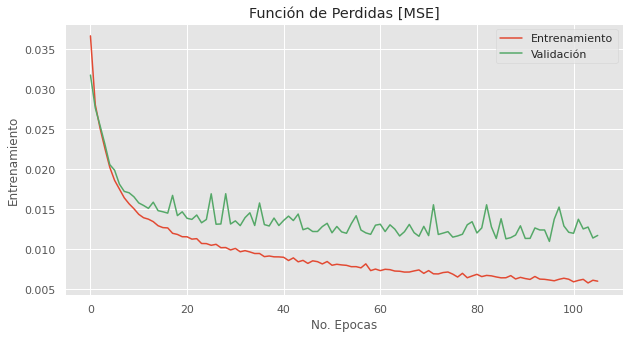

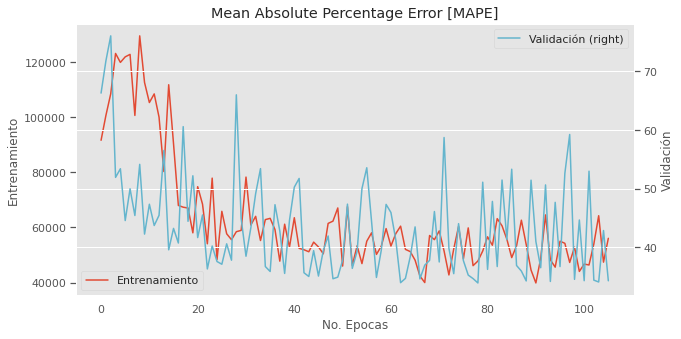

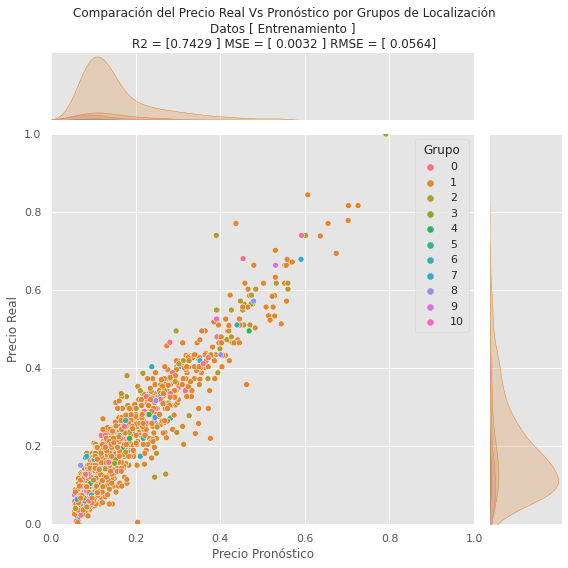

No handles with labels found to put in legend.


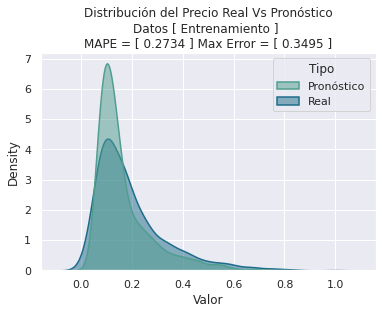

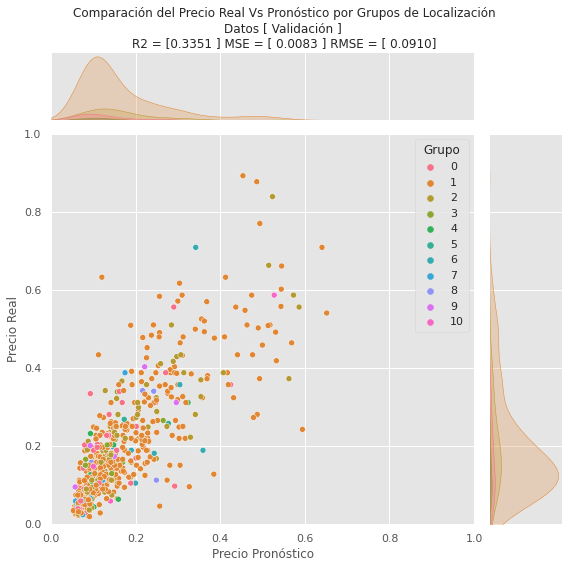

No handles with labels found to put in legend.


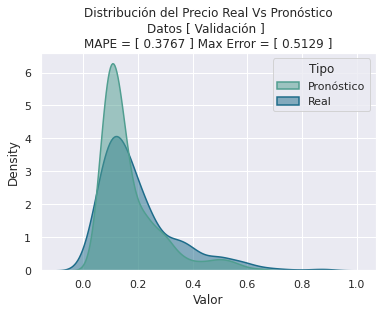

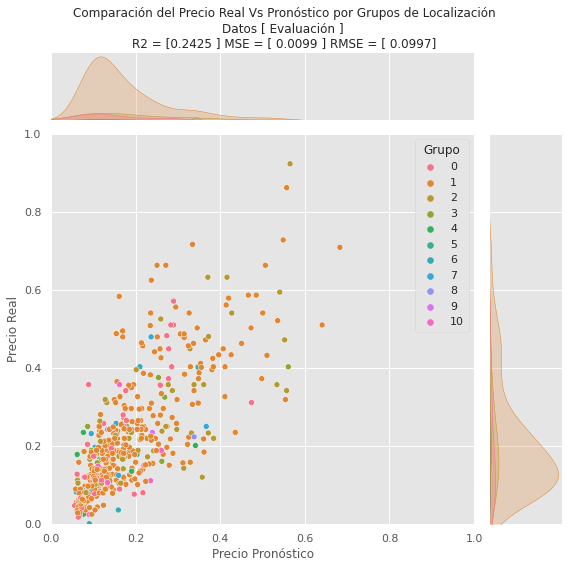

No handles with labels found to put in legend.


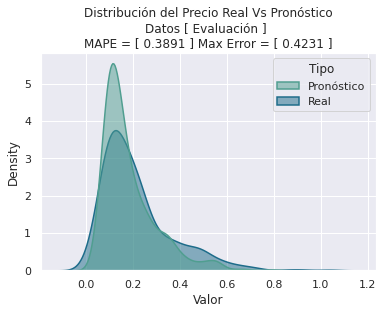

In [ ]:
NoExperimento = 14
FOLDER_EXP =BASE_FOLDER+'MC1_'+str(NoExperimento)+'/'
#RMSprop, 0.001

ModeloCandidatoNo2 =RedNeuronal(dtrain.shape[1], int(dtrain.shape[1]/6), 1.6, 'ReLu', 'L2', 0.0001, 'RMSprop', 0.001, 1000, 64)
ModeloCandidatoNo2.Crea_RN()
ModeloCandidatoNo2.Entrenamiento(FOLDER_EXP, dtrain, dy_train, dval, dy_val)
# grafica el modelo de la red neuronal
ModeloCandidatoNo2.model.save(FOLDER_EXP+"Modelo.h5") 
dot_img_file = FOLDER_EXP+'modeloRedNeuronal.png'
tf.keras.utils.plot_model(ModeloCandidatoNo2.model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)
# graficas del entrenamiento
GraficasEntrenamiento(ModeloCandidatoNo2.hist, 'loss', FOLDER_EXP)
GraficasEntrenamiento(ModeloCandidatoNo2.hist, 'MAPE', FOLDER_EXP)

# Evaluacion del modelo con datos de ENTRENAMIENTO
ModeloCandidatoNo2.EvaluacionEntrenamiento(dtrain, dy_train)
y_grupo= pd.DataFrame(dcuant_train.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_train = ModeloCandidatoNo2.df_datos
df_train['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Entrenamiento', df_train, ModeloCandidatoNo2.r2, ModeloCandidatoNo2.mse, ModeloCandidatoNo2.rmse)
df_datos = ModeloCandidatoNo2.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Entrenamiento', df,  ModeloCandidatoNo2.mape, ModeloCandidatoNo2.maxe)
if NoExperimento==9:
  data = {'Metrica': ['Entrenamiento'],
          'Experimento': [NoExperimento],
          'RMSE': [ModeloCandidatoNo2.rmse],
          'R2': [ModeloCandidatoNo2.r2],
          'MAPE': [ ModeloCandidatoNo2.mape],
          'MAX ERR': [ ModeloCandidatoNo2.maxe]
          }
  df_metricas1 = pd.DataFrame(data)
else:
  new_row = {'Metrica':'Entrenamiento', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo2.mse, 'R2':ModeloCandidatoNo2.r2, 'MAPE':ModeloCandidatoNo2.mape, 'MAX ERR':ModeloCandidatoNo2.maxe}
  #append row to the dataframe
  df_metricas1 = df_metricas1.append(new_row, ignore_index=True)

# Evaluacion del modelo con datos de VALIDACION
ModeloCandidatoNo2.EvaluacionEntrenamiento(dval, dy_val)
y_grupo= pd.DataFrame(dcuant_val.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_train = ModeloCandidatoNo2.df_datos
df_train['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Validación', df_train, ModeloCandidatoNo2.r2, ModeloCandidatoNo2.mse, ModeloCandidatoNo2.rmse)
df_datos = ModeloCandidatoNo2.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Validación', df,  ModeloCandidatoNo2.mape, ModeloCandidatoNo2.maxe)
if NoExperimento==1:
  data = {'Metrica': ['Validación'],
          'Experimento': [NoExperimento],
          'RMSE': [ModeloCandidatoNo2.rmse],
          'R2': [ModeloCandidatoNo2.r2],
          'MAPE': [ ModeloCandidatoNo2.mape],
          'MAX ERR': [ ModeloCandidatoNo2.maxe]
          }
  df_metricas1 = pd.DataFrame(data)
else:
  new_row = {'Metrica':'Validación', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo2.mse, 'R2':ModeloCandidatoNo2.r2, 'MAPE':ModeloCandidatoNo2.mape, 'MAX ERR':ModeloCandidatoNo2.maxe}
  #append row to the dataframe
  df_metricas1 = df_metricas1.append(new_row, ignore_index=True)

# Evaluacion del modelo con datos de EVALUACION
ModeloCandidatoNo2.EvaluacionEntrenamiento(dtest, dy_test)
y_grupo= pd.DataFrame(dcuant_test.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_train = ModeloCandidatoNo2.df_datos
df_train['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Evaluación', df_train, ModeloCandidatoNo2.r2, ModeloCandidatoNo2.mse, ModeloCandidatoNo2.rmse)
df_datos = ModeloCandidatoNo2.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Evaluación', df,  ModeloCandidatoNo2.mape, ModeloCandidatoNo2.maxe)
if NoExperimento==1:
  data = {'Metrica': ['Evaluación'],
          'Experimento': [NoExperimento],
          'RMSE': [ModeloCandidatoNo2.rmse],
          'R2': [ModeloCandidatoNo2.r2],
          'MAPE': [ ModeloCandidatoNo2.mape],
          'MAX ERR': [ ModeloCandidatoNo2.maxe]
          }
  df_metricas1 = pd.DataFrame(data)
else:
  new_row = {'Metrica':'Evaluación', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo2.mse, 'R2':ModeloCandidatoNo2.r2, 'MAPE':ModeloCandidatoNo2.mape, 'MAX ERR':ModeloCandidatoNo2.maxe}
  #append row to the dataframe
  df_metricas1 = df_metricas1.append(new_row, ignore_index=True)


# Experimentos del Modelo Candidato No2

## Experimento No 1 del Modelo Candidato No. 2
### Hiperparametros fijos: 
- Dimension del vector latente Z = 10
- Sin Regularizador
- No Epocas = 500
- Batchsize = 32

### Hiperparametros que van a variar: 
- No de capas:  2 capas, 3 capas 4 y 5 capas ocultas. 

experimentos 1, 2, 3, y 4

## Experimento No 2, Hipotesis: No de batchsize influye en los resultados del Auto Encoder 
### Hiperparametros fijos: 
- Dimension del vector latente Z = 10
- Sin Regularizador
- No Epocas = 500
- No de capas:  3 capas ocultas. 

### Hiperparametros que van a variar: 
- Batchsize = 32, 64, 128 y 16
experimentos 2, 5, 6 y 7

## Experimento No 3, Hipotesis: cambio del tamaño del vector latente influye en los resultados del Auto Encoder 
### Hiperparametros fijos: 


- Batchsize = 32
- No Epocas = 500
- No de capas:  3 capas ocultas. 
- Sin Regularizador
-Inicializador

### Hiperparametros que van a variar:

- Dimension del vector latente Z = 10 , 5, 15, 20

experimentos 5, 8, 9 y 10

## Experimento No 4, Hipotesis: Sin Regularizador, con regularizador influye en los resultados del Auto Encoder 
### Hiperparametros fijos: 
- Dimension del vector latente Z = 20
- Batchsize = 32
- No Epocas = 500
- No de capas:  3 capas ocultas. 

### Hiperparametros que van a variar: 
- Sin Regularizador
- Con regularizador L1, lambda de 0.0001
- Con regularizador L2, lambda de 0.001, 0.0001
experimentos 10, 11, 12 y 13

## Experimento No 5, Hipotesis: uso de inicializador de actividad influye en los resultados del Auto Encoder 
### Hiperparametros fijos: 

- Dimension del vector latente Z = 20
- Batchsize = 32
- No Epocas = 500
- No de capas: 3 capas ocultas. 
- Regularizador L2 0.00001

### Hiperparametros que van a variar:

Inicializador

experimentos GrothNomal, HeNormal


[INFO]: Entrenando la red...


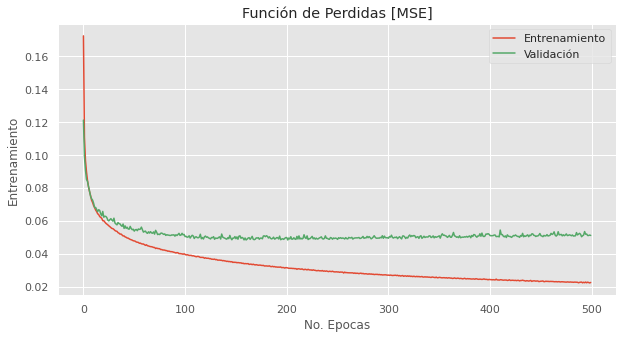

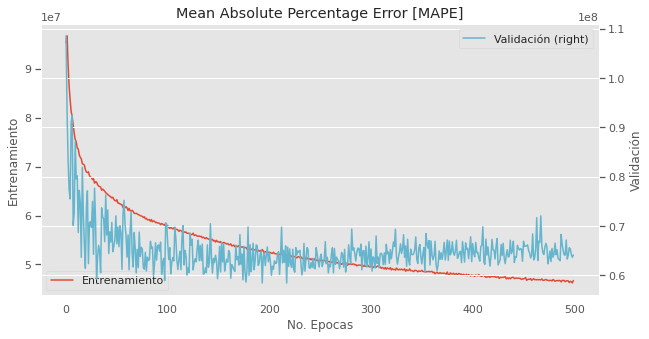

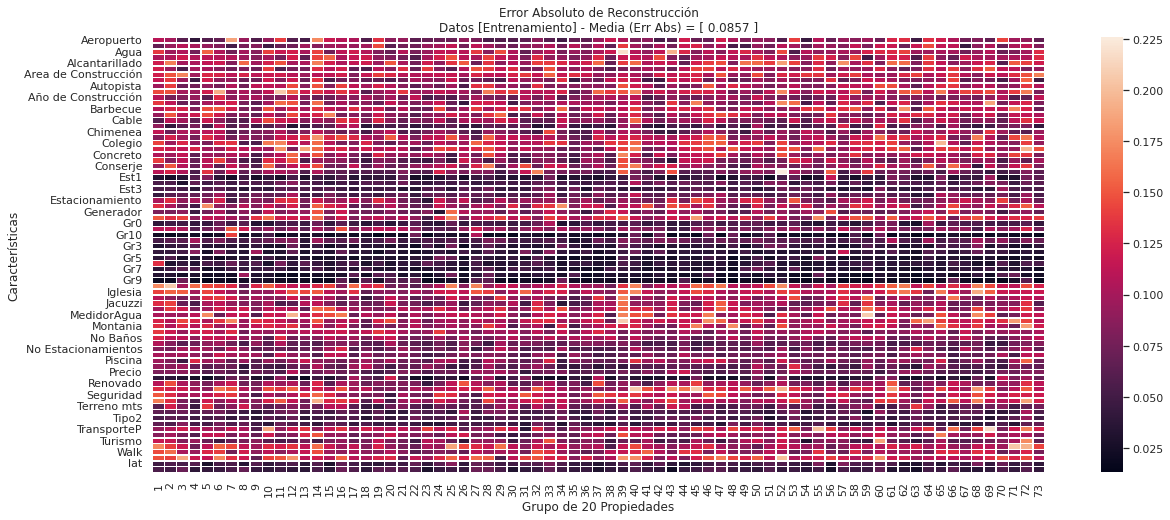

No handles with labels found to put in legend.


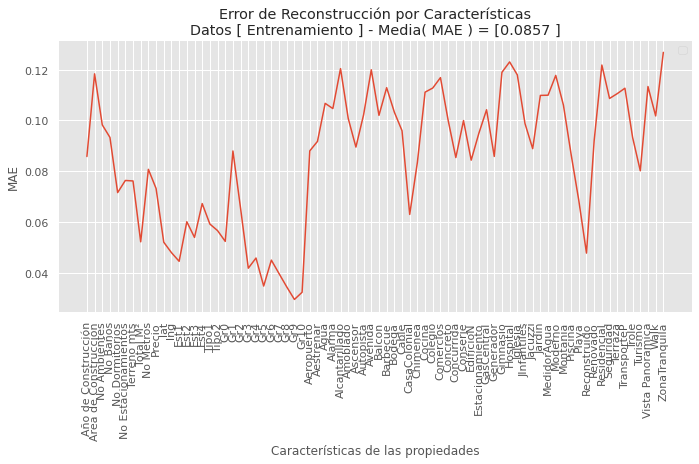

<Figure size 936x360 with 0 Axes>

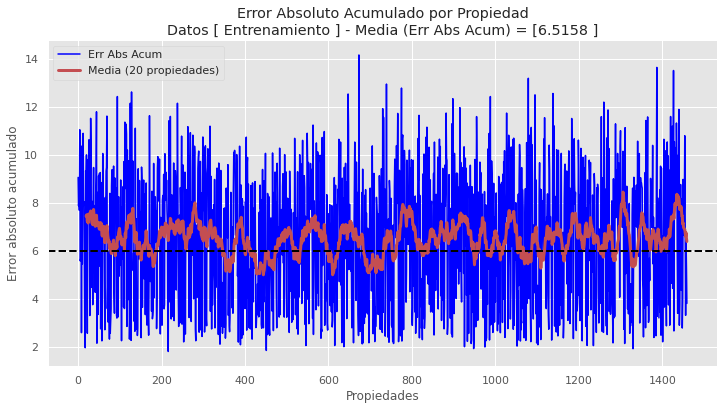

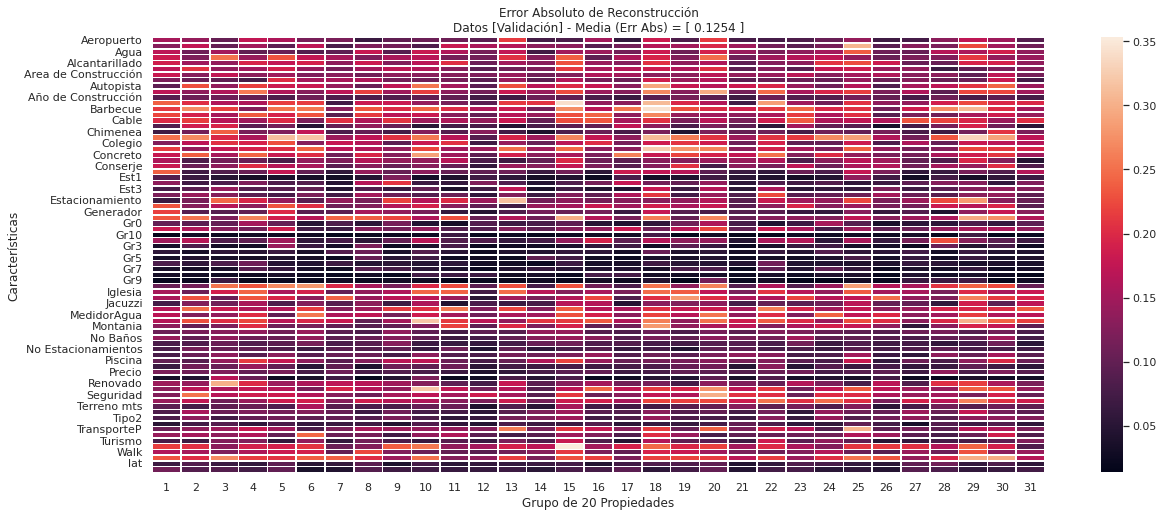

No handles with labels found to put in legend.


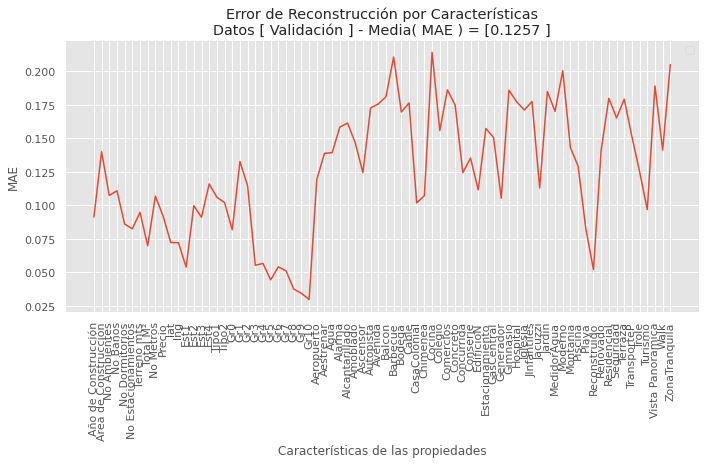

<Figure size 936x360 with 0 Axes>

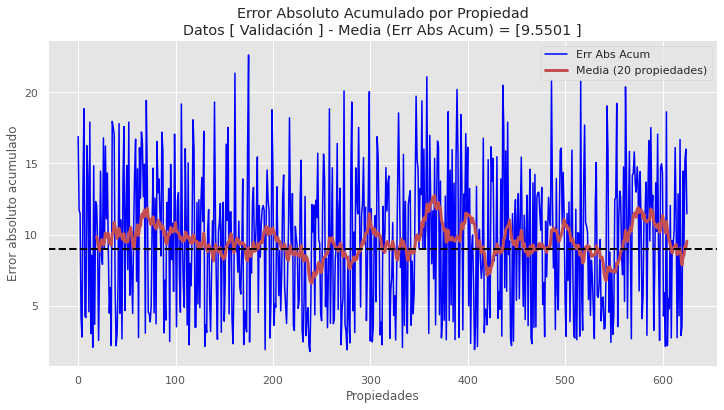

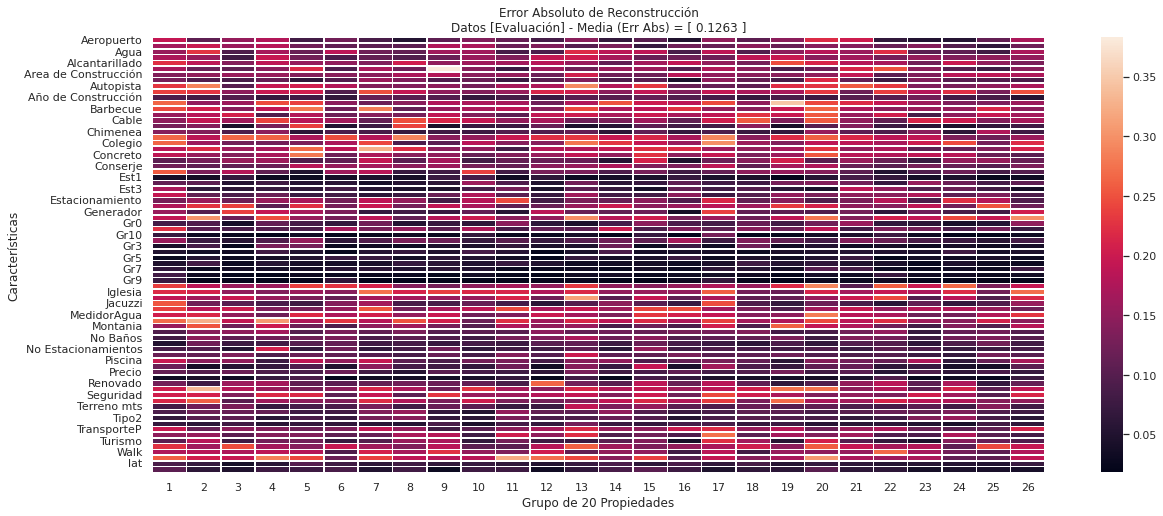

No handles with labels found to put in legend.


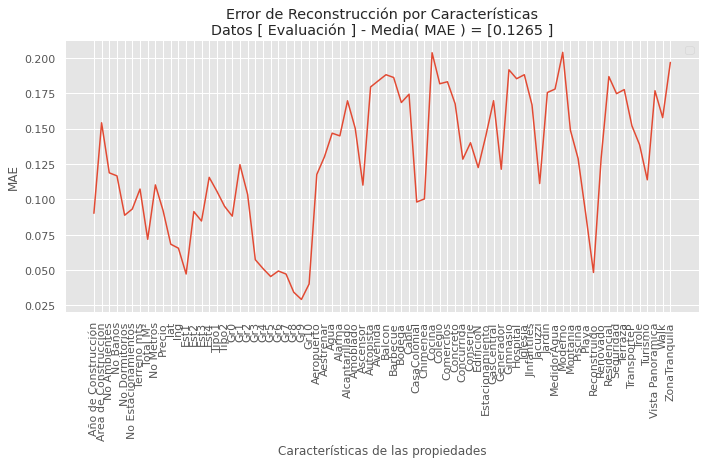

<Figure size 936x360 with 0 Axes>

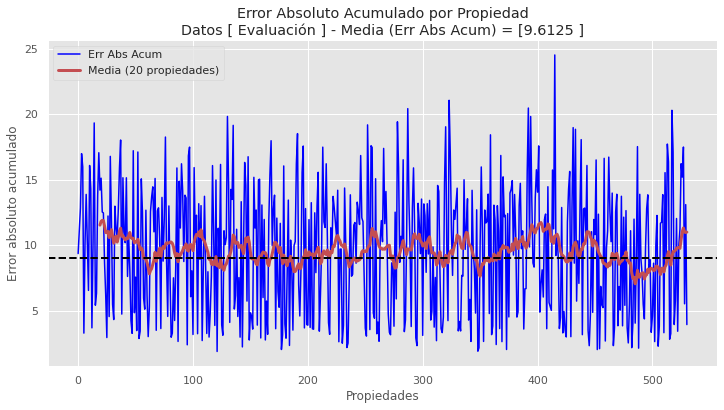

Vector latente Train: (1460, 20)
Vector latente Val: (626, 20)


In [ ]:
NoExperimento = 14
FOLDER_EXP =BASE_FOLDER+'MC2_'+str(NoExperimento)+'/'

AE2Capas = AutoEncoder(20, dtrain_AE.shape[1], 5, 'L2', 0.0001, True, False)

AE2Capas.Crea_AutoEncoder()
AE2Capas.Entrena(FOLDER_EXP, dtrain_AE, dval_AE, 500, 64)

AE2Capas.Predecir(FOLDER_EXP, dtrain_AE, dval_AE, dtest_AE,  dtrain_AE.columns)


Salida_VectorLatente_train= pd.DataFrame(AE2Capas.encoder.predict(dtrain_AE))
Salida_VectorLatente_train.rename(columns={0:'DimZ0', 1:'DimZ1', 2:'DimZ2', 3:'DimZ3', 4:'DimZ4', 5:'DimZ5', 6:'DimZ6', 7:'DimZ7', 8:'DimZ8', 9:'DimZ9', 
                                            10:'DimZ10', 11:'DimZ11', 12:'DimZ12', 13:'DimZ13', 14:'DimZ14', 15:'DimZ15', 16:'DimZ16', 17:'DimZ17', 18:'DimZ18', 19:'DimZ19',
                                           20:'DimZ20', 21:'DimZ21', 22:'DimZ22', 23:'DimZ23', 24:'DimZ24', 25:'DimZ25', 26:'DimZ26', 27:'DimZ27', 28:'DimZ28', 29:'DimZ29'}, inplace=True)

Salida_VectorLatente_val= pd.DataFrame(AE2Capas.encoder.predict(dval_AE))
Salida_VectorLatente_val.rename(columns={0:'DimZ0', 1:'DimZ1', 2:'DimZ2', 3:'DimZ3', 4:'DimZ4', 5:'DimZ5', 6:'DimZ6', 7:'DimZ7', 8:'DimZ8', 9:'DimZ9', 
                                            10:'DimZ10', 11:'DimZ11', 12:'DimZ12', 13:'DimZ13', 14:'DimZ14', 15:'DimZ15', 16:'DimZ16', 17:'DimZ17', 18:'DimZ18', 19:'DimZ19',
                                           20:'DimZ20', 21:'DimZ21', 22:'DimZ22', 23:'DimZ23', 24:'DimZ24', 25:'DimZ25', 26:'DimZ26', 27:'DimZ27', 28:'DimZ28', 29:'DimZ29'}, inplace=True)

print('Vector latente Train: ' + str(Salida_VectorLatente_train.shape))
print('Vector latente Val: ' + str(Salida_VectorLatente_val.shape))

Salida_VectorLatente_test= pd.DataFrame(AE2Capas.encoder.predict(dtest_AE))
Salida_VectorLatente_test.rename(columns={0:'DimZ0', 1:'DimZ1', 2:'DimZ2', 3:'DimZ3', 4:'DimZ4', 5:'DimZ5', 6:'DimZ6', 7:'DimZ7', 8:'DimZ8', 9:'DimZ9', 
                                           10:'DimZ10', 11:'DimZ11', 12:'DimZ12', 13:'DimZ13', 14:'DimZ14', 15:'DimZ15', 16:'DimZ16', 17:'DimZ17', 18:'DimZ18', 19:'DimZ19',
                                           20:'DimZ20', 21:'DimZ21', 22:'DimZ22', 23:'DimZ23', 24:'DimZ24', 25:'DimZ25', 26:'DimZ26', 27:'DimZ27', 28:'DimZ28', 29:'DimZ29'}, inplace=True)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (Flatten)           (None, 20)                0         
                                                                 
 Oculta_1 (Dense)            (None, 15)                315       
                                                                 
 Oculta_2 (Dense)            (None, 11)                176       
                                                                 
 Oculta_3 (Dense)            (None, 8)                 96        
                                                                 
 Salida (Dense)              (None, 1)                 9         
                                                                 
Total params: 596
Trainable params: 596
Non-trainable params: 0
_________________________________________________________________


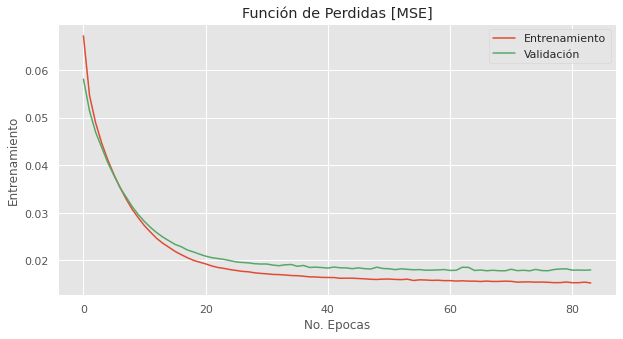

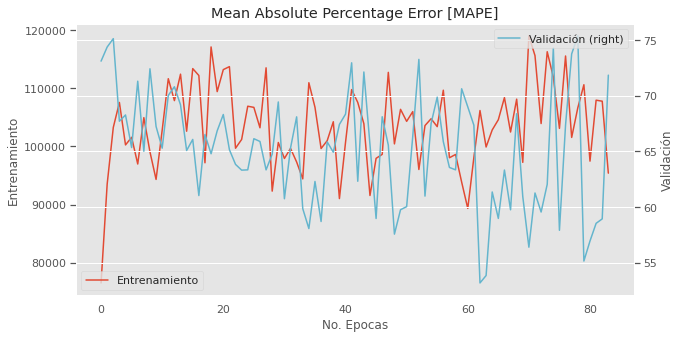

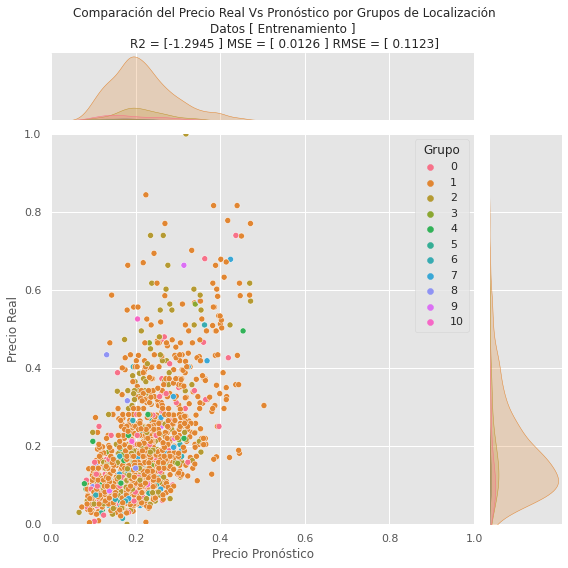

No handles with labels found to put in legend.


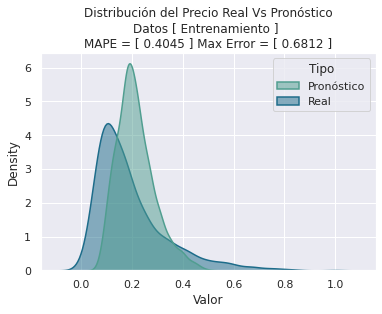

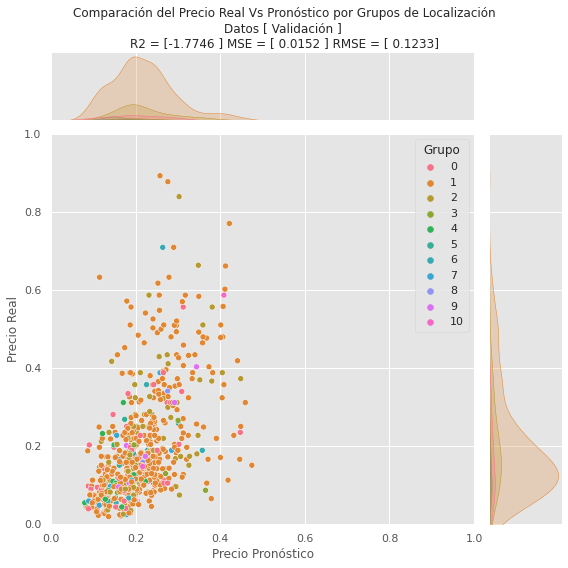

No handles with labels found to put in legend.


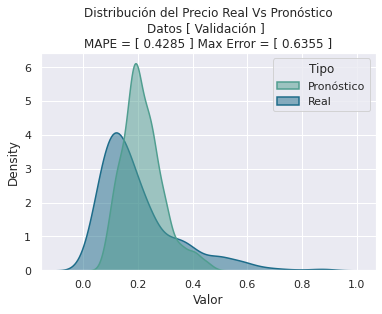

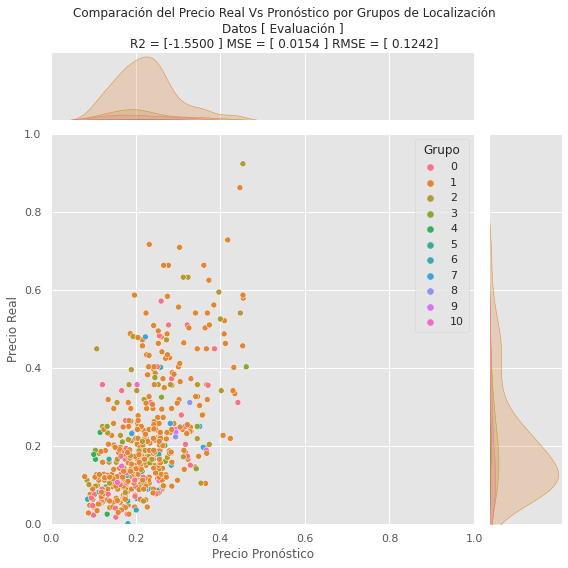

No handles with labels found to put in legend.


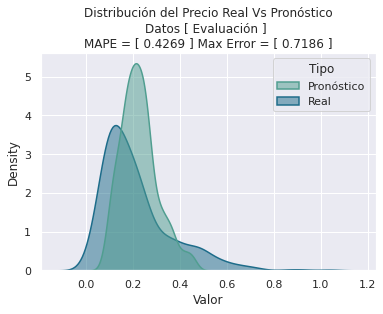

In [ ]:
ModeloCandidatoNo2 =RedNeuronal(Salida_VectorLatente_val.shape[1], int(Salida_VectorLatente_train.shape[1]/3), 1.3, 'ReLu', 'L2', 0.001, 'RMSprop', 0.001, 1000, 64)
ModeloCandidatoNo2.Crea_RN()
ModeloCandidatoNo2.Entrenamiento(FOLDER_EXP, Salida_VectorLatente_train, dy_train, Salida_VectorLatente_val, dy_val)

# grafica el modelo de la red neuronal
ModeloCandidatoNo2.model.save(FOLDER_EXP+"Modelo.h5") 
dot_img_file = FOLDER_EXP+'modeloRedNeuronal.png'
tf.keras.utils.plot_model(ModeloCandidatoNo2.model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)
# graficas del entrenamiento
GraficasEntrenamiento(ModeloCandidatoNo2.hist, 'loss', FOLDER_EXP)
GraficasEntrenamiento(ModeloCandidatoNo2.hist, 'MAPE', FOLDER_EXP)
# Evaluacion del modelo con datos de validacion
ModeloCandidatoNo2.EvaluacionEntrenamiento(Salida_VectorLatente_train, dy_train)

# Evaluacion del modelo con datos de ENTRENAMIENTO
ModeloCandidatoNo2.EvaluacionEntrenamiento(Salida_VectorLatente_train, dy_train)
y_grupo= pd.DataFrame(dcuant_train.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_train = ModeloCandidatoNo2.df_datos
df_train['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Entrenamiento', df_train, ModeloCandidatoNo2.r2, ModeloCandidatoNo2.mse, ModeloCandidatoNo2.rmse)
df_datos = ModeloCandidatoNo2.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Entrenamiento', df,  ModeloCandidatoNo2.mape, ModeloCandidatoNo2.maxe)
if NoExperimento==11:
  data = {'Metrica': ['Entrenamiento'],
          'Experimento': [NoExperimento],
          'RMSE': [ModeloCandidatoNo2.rmse],
          'R2': [ModeloCandidatoNo2.r2],
          'MAPE': [ ModeloCandidatoNo2.mape],
          'MAX ERR': [ ModeloCandidatoNo2.maxe]
          }
  df_metricas2 = pd.DataFrame(data)
else:
  new_row = {'Metrica':'Entrenamiento', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo2.mse, 'R2':ModeloCandidatoNo2.r2, 'MAPE':ModeloCandidatoNo2.mape, 'MAX ERR':ModeloCandidatoNo2.maxe}
  #append row to the dataframe
  df_metricas2 = df_metricas2.append(new_row, ignore_index=True)

# Evaluacion del modelo con datos de VALIDACION
ModeloCandidatoNo2.EvaluacionEntrenamiento(Salida_VectorLatente_val, dy_val)
y_grupo= pd.DataFrame(dcuant_val.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_train = ModeloCandidatoNo2.df_datos
df_train['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Validación', df_train, ModeloCandidatoNo2.r2, ModeloCandidatoNo2.mse, ModeloCandidatoNo2.rmse)
df_datos = ModeloCandidatoNo2.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Validación', df,  ModeloCandidatoNo2.mape, ModeloCandidatoNo2.maxe)
if NoExperimento==1:
  data = {'Metrica': ['Validación'],
          'Experimento': [NoExperimento],
          'RMSE': [ModeloCandidatoNo2.rmse],
          'R2': [ModeloCandidatoNo2.r2],
          'MAPE': [ ModeloCandidatoNo2.mape],
          'MAX ERR': [ ModeloCandidatoNo2.maxe]
          }
  df_metricas2 = pd.DataFrame(data)
else:
  new_row = {'Metrica':'Validación', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo2.mse, 'R2':ModeloCandidatoNo2.r2, 'MAPE':ModeloCandidatoNo2.mape, 'MAX ERR':ModeloCandidatoNo2.maxe}
  #append row to the dataframe
  df_metricas2 = df_metricas2.append(new_row, ignore_index=True)

# Evaluacion del modelo con datos de EVALUACION
ModeloCandidatoNo2.EvaluacionEntrenamiento(Salida_VectorLatente_test, dy_test)
y_grupo= pd.DataFrame(dcuant_test.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_train = ModeloCandidatoNo2.df_datos
df_train['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Evaluación', df_train, ModeloCandidatoNo2.r2, ModeloCandidatoNo2.mse, ModeloCandidatoNo2.rmse)
df_datos = ModeloCandidatoNo2.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Evaluación', df,  ModeloCandidatoNo2.mape, ModeloCandidatoNo2.maxe)
if NoExperimento==1:
  data = {'Metrica': ['Evaluación'],
          'Experimento': [NoExperimento],
          'RMSE': [ModeloCandidatoNo2.rmse],
          'R2': [ModeloCandidatoNo2.r2],
          'MAPE': [ ModeloCandidatoNo2.mape],
          'MAX ERR': [ ModeloCandidatoNo2.maxe]
          }
  df_metricas2 = pd.DataFrame(data)
else:
  new_row = {'Metrica':'Evaluación', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo2.mse, 'R2':ModeloCandidatoNo2.r2, 'MAPE':ModeloCandidatoNo2.mape, 'MAX ERR':ModeloCandidatoNo2.maxe}
  #append row to the dataframe
  df_metricas2 = df_metricas2.append(new_row, ignore_index=True)

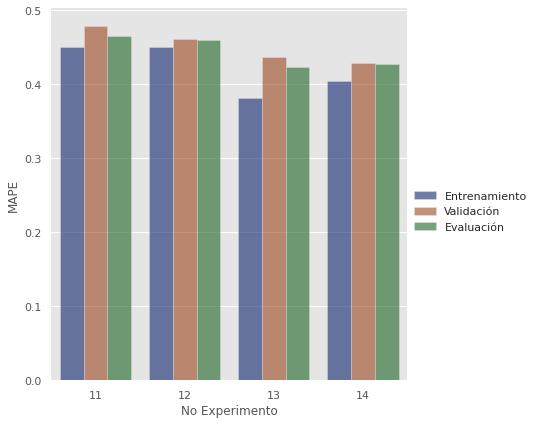

In [ ]:
GraficasMetricas(FOLDER_EXP, 'MAPE',df_metricas2)

In [ ]:
df_metricas2

,Metrica,Experimento,RMSE,R2,MAPE,MAX ERR
0,Entrenamiento,1,0.119377,-0.803103,0.425369,0.679545
1,Entrenamiento,2,0.013646,-2.103675,0.444046,0.641801
2,Entrenamiento,2,0.015645,-2.904518,0.473933,0.705307
3,Entrenamiento,2,0.015833,-2.402107,0.438734,0.678690
4,Entrenamiento,3,0.014172,-2.391004,0.450262,0.725952
5,Entrenamiento,3,0.016537,-3.742859,0.499456,0.713986
6,Entrenamiento,3,0.017624,-3.629928,0.488849,0.765524
7,Entrenamiento,4,0.012736,-1.222566,0.426605,0.733817
8,Validación,4,0.015043,-1.549553,0.466678,0.678338
9,Evaluación,4,0.015312,-1.302254,0.442548,0.771371


In [ ]:
df_metricas2 = df_metricas2.drop(index=[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [ ]:
#df_metricas.at[9, 'Experimento'] = 13

# Experimentos del Modelo Candidato No3

## preparar Datos

In [ ]:
dtrain.columns

Index(['Año de Construcción', 'Area de Construcción', 'No Ambientes',
       'No Baños', 'No Dormitorios', 'No Estacionamientos', 'Terreno mts',
       'Total M²', 'No Metros', 'lat', 'lng', 'Est1', 'Est2', 'Est3', 'Est4',
       'Tipo1', 'Tipo2', 'Gr0', 'Gr1', 'Gr2', 'Gr3', 'Gr4', 'Gr5', 'Gr6',
       'Gr7', 'Gr8', 'Gr9', 'Gr10', 'Aeropuerto', 'Aestrenar', 'Agua',
       'Alarma', 'Alcantarillado', 'Amoblado', 'Ascensor', 'Autopista',
       'Avenida', 'Balcon', 'Barbecue', 'Bodega', 'Cable', 'CasaColonial',
       'Chimenea', 'Cocina', 'Colegio', 'Comercios', 'Concreto', 'Concurrida',
       'Conserje', 'EdificioN', 'Estacionamiento', 'GasCentral', 'Generador',
       'Gimnasio', 'Hospital', 'Iglesia', 'JInfantiles', 'Jacuzzi', 'Jardin',
       'MedidorAgua', 'Moderno', 'Montania', 'Piscina', 'Playa',
       'Reconstruido', 'Renovado', 'Residencial', 'Seguridad', 'Terraza',
       'TransporteP', 'Trole', 'Turismo', 'Vista Panoramica', 'Walk',
       'ZonaTranquila'],
      dtype='obj

In [ ]:
# datos cuantitativos 
dcuant_train = dtrain.iloc[:,0:28]
dcuant_val = dval.iloc[:,0:28]
dcuant_test = dtest.iloc[:,0:28]
# datos binarios para el autoEncoder
dbin_train = dtrain.iloc[:,28:]
dbin_val = dval.iloc[:,28:]
dbin_test = dtest.iloc[:,28:]

## Experimento No 1 del Modelo Candidato No. 3
### Hiperparametros fijos: 
- Dimension del vector latente Z = 20
- Sin Regularizador
- No Epocas = 500
- Batchsize = 32

### Hiperparametros que van a variar: 
- No de capas:  2 capas, 3 capas 4 y 5 capas ocultas. 

experimentos 1, 2, 3, y 4

## Experimento No 2, Hipotesis: No de batchsize influye en los resultados del Auto Encoder 
### Hiperparametros fijos: 
- Dimension del vector latente Z = 10
- Sin Regularizador
- No Epocas = 500
- No de capas:  3 capas ocultas. 

### Hiperparametros que van a variar: 
- Batchsize = 32, 16, 64, 128
experimentos 2, 5, 6 y 7

## Experimento No 3, Hipotesis: cambio del tamaño del vector latente influye en los resultados del Auto Encoder 
### Hiperparametros fijos: 


- Batchsize = 64
- No Epocas = 500
- No de capas:  3 capas ocultas. 
- Sin Regularizador
-Inicializador

### Hiperparametros que van a variar:

- Dimension del vector latente Z = 5, 10 , 15, 20

experimentos 5, 8, 9 y 10

## Experimento No 4, Hipotesis: Sin Regularizador, con regularizador influye en los resultados del Auto Encoder 
### Hiperparametros fijos: 
- Dimension del vector latente Z = 20
- Batchsize = 32
- No Epocas = 500
- No de capas:  3 capas ocultas. 

### Hiperparametros que van a variar: 
- Sin Regularizador
- Con regularizador L1, lambda de 0.001
- Con regularizador L2, lambda de 0.001, 0.0001
experimentos 10, 11, 12 y 13

[INFO]: Entrenando la red...


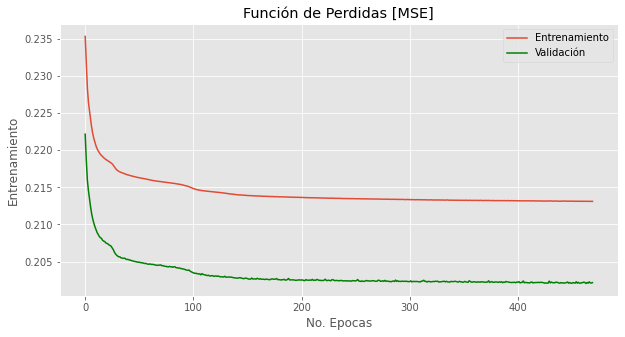

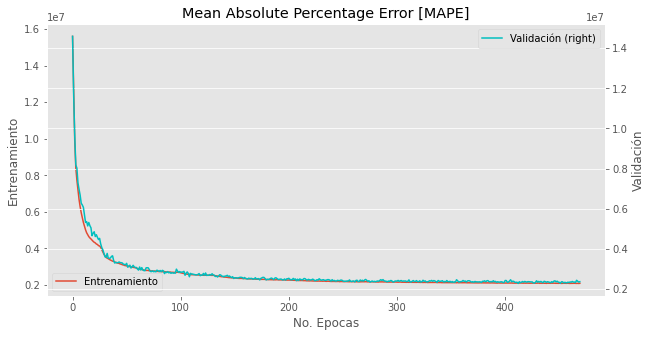

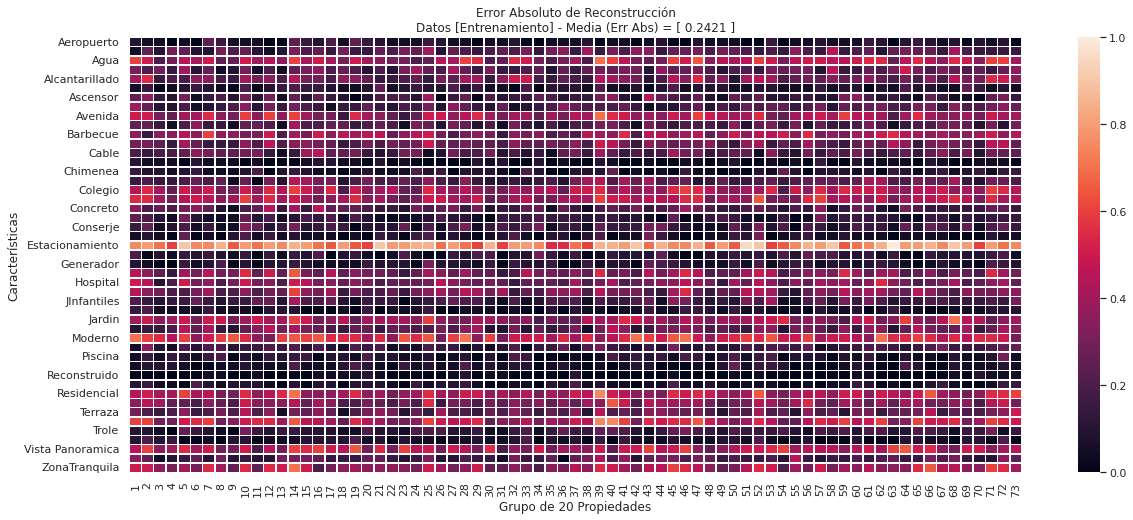

No handles with labels found to put in legend.


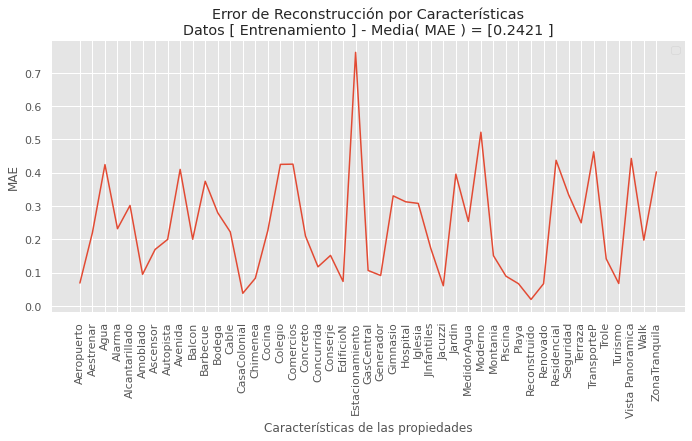

<Figure size 936x360 with 0 Axes>

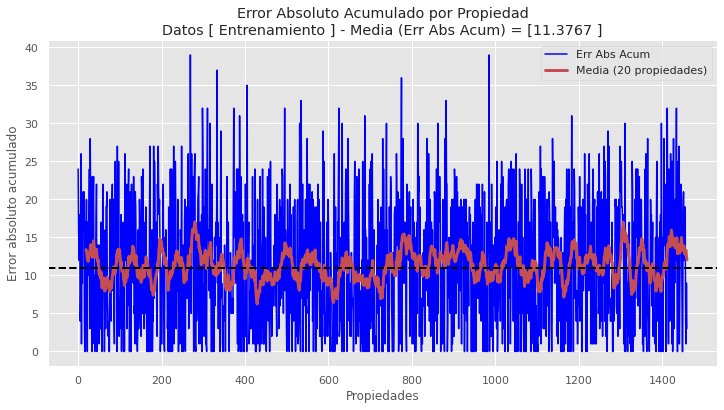

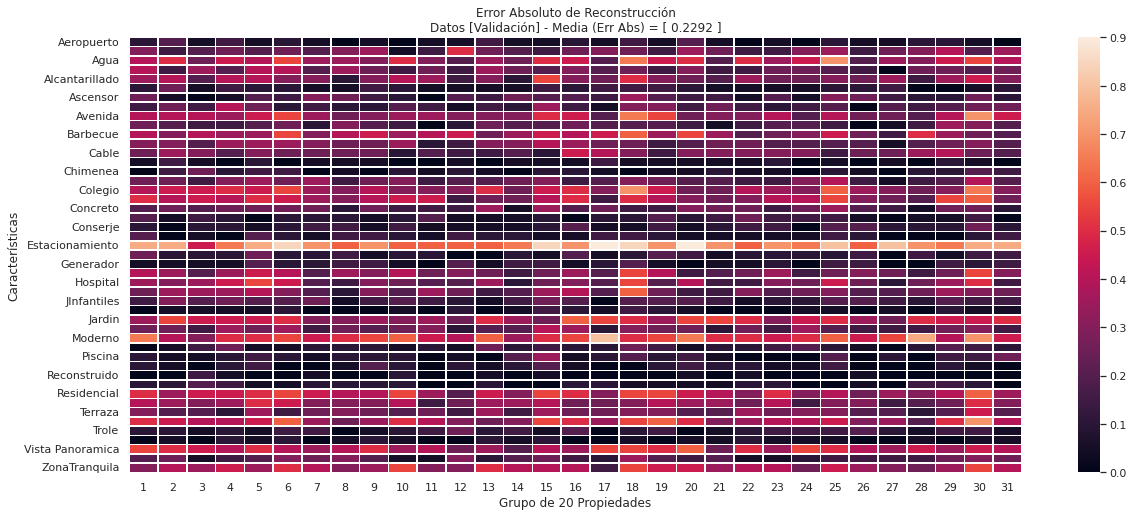

No handles with labels found to put in legend.


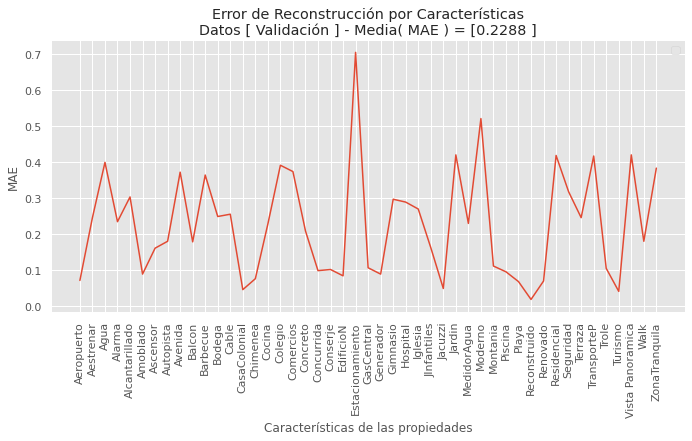

<Figure size 936x360 with 0 Axes>

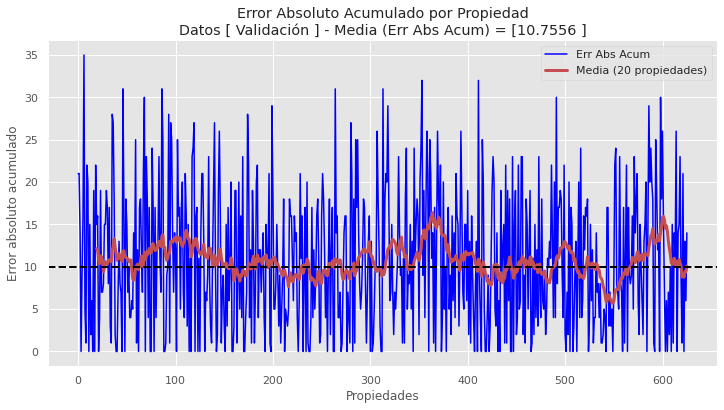

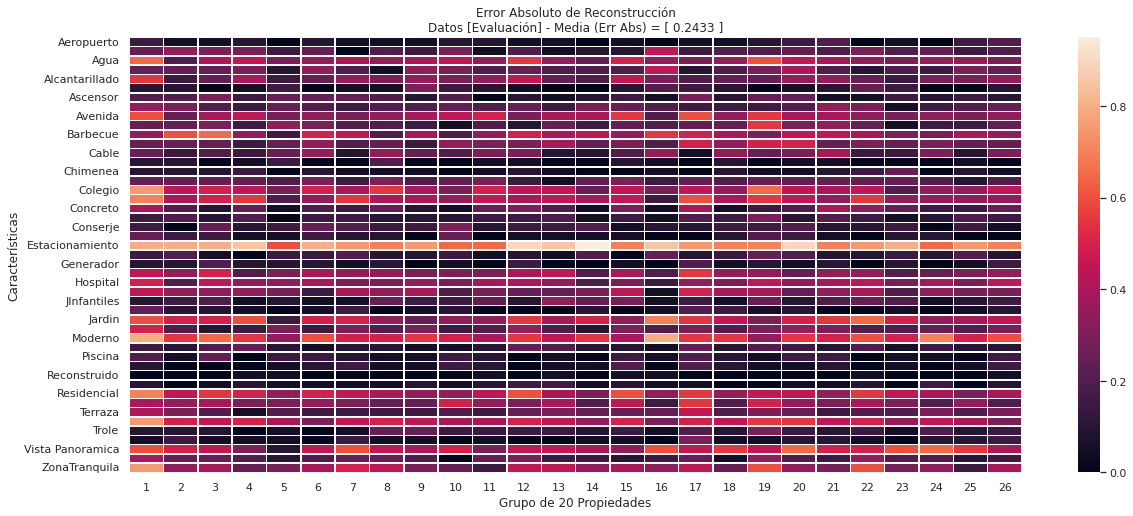

No handles with labels found to put in legend.


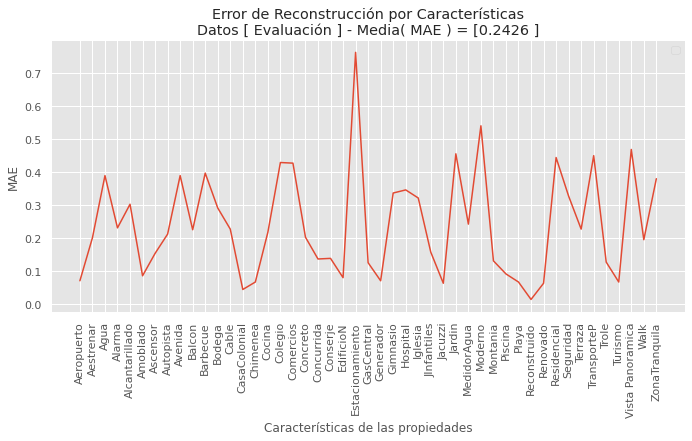

<Figure size 936x360 with 0 Axes>

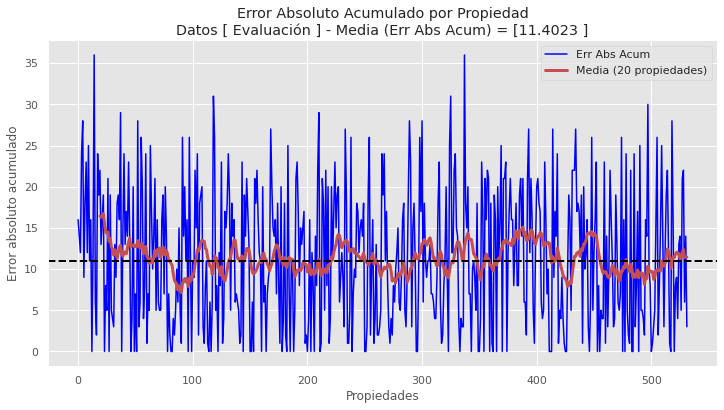

Vector latente Train: (1460, 5)
Vector latente Val: (626, 5)


In [ ]:
NoExperimento = 50
FOLDER_EXP =BASE_FOLDER+'MC3_'+str(NoExperimento)+'/'

AE2Capas = AutoEncoder(5, dbin_train.shape[1], 3, 'L2', 0.0001, False, True)
AE2Capas.Crea_AutoEncoder()
AE2Capas.Entrena(FOLDER_EXP, dbin_train, dbin_val, 500, 64)

AE2Capas.Predecir(FOLDER_EXP, dbin_train, dbin_val, dbin_test,  dbin_train.columns)

Salida_VectorLatente_train= pd.DataFrame(AE2Capas.encoder.predict(dbin_train))
Salida_VectorLatente_train.rename(columns={0:'DimZ0', 1:'DimZ1', 2:'DimZ2', 3:'DimZ3', 4:'DimZ4', 5:'DimZ5', 6:'DimZ6', 7:'DimZ7', 8:'DimZ8', 9:'DimZ9', 
                                           10:'DimZ10', 11:'DimZ11', 12:'DimZ12', 13:'DimZ13', 14:'DimZ14', 15:'DimZ15', 16:'DimZ16', 17:'DimZ17', 18:'DimZ18', 19:'DimZ19',
                                           20:'DimZ20', 21:'DimZ21', 22:'DimZ22', 23:'DimZ23', 24:'DimZ24', 25:'DimZ25', 26:'DimZ26', 27:'DimZ27', 28:'DimZ28', 29:'DimZ29'}, inplace=True)
Salida_VectorLatente_val= pd.DataFrame(AE2Capas.encoder.predict(dbin_val))
Salida_VectorLatente_val.rename(columns={0:'DimZ0', 1:'DimZ1', 2:'DimZ2', 3:'DimZ3', 4:'DimZ4', 5:'DimZ5', 6:'DimZ6', 7:'DimZ7', 8:'DimZ8', 9:'DimZ9', 
                                           10:'DimZ10', 11:'DimZ11', 12:'DimZ12', 13:'DimZ13', 14:'DimZ14', 15:'DimZ15', 16:'DimZ16', 17:'DimZ17', 18:'DimZ18', 19:'DimZ19',
                                           20:'DimZ20', 21:'DimZ21', 22:'DimZ22', 23:'DimZ23', 24:'DimZ24', 25:'DimZ25', 26:'DimZ26', 27:'DimZ27', 28:'DimZ28', 29:'DimZ29'}, inplace=True)
print('Vector latente Train: ' + str(Salida_VectorLatente_train.shape))
print('Vector latente Val: ' + str(Salida_VectorLatente_val.shape))

Salida_VectorLatente_test= pd.DataFrame(AE2Capas.encoder.predict(dbin_test))
Salida_VectorLatente_test.rename(columns={0:'DimZ0', 1:'DimZ1', 2:'DimZ2', 3:'DimZ3', 4:'DimZ4', 5:'DimZ5', 6:'DimZ6', 7:'DimZ7', 8:'DimZ8', 9:'DimZ9', 
                                           10:'DimZ10', 11:'DimZ11', 12:'DimZ12', 13:'DimZ13', 14:'DimZ14', 15:'DimZ15', 16:'DimZ16', 17:'DimZ17', 18:'DimZ18', 19:'DimZ19',
                                           20:'DimZ20', 21:'DimZ21', 22:'DimZ22', 23:'DimZ23', 24:'DimZ24', 25:'DimZ25', 26:'DimZ26', 27:'DimZ27', 28:'DimZ28', 29:'DimZ29'}, inplace=True)




In [ ]:
# juntar los datos cuantitativos con el vector latente del autoencoder
dred_train = pd.concat([dcuant_train, Salida_VectorLatente_train], axis=1)
print(dcuant_train.shape)
print(Salida_VectorLatente_train.shape)
print(dred_train.shape)
dred_val = pd.concat([dcuant_val, Salida_VectorLatente_val], axis=1)
print(dcuant_val.shape)
print(Salida_VectorLatente_val.shape)
print(dred_val.shape)
dred_test = pd.concat([dcuant_test, Salida_VectorLatente_test], axis=1)
print(dcuant_test.shape)
print(Salida_VectorLatente_test.shape)
print(dred_test.shape)

(1460, 28)
(1460, 5)
(1460, 33)
(626, 28)
(626, 5)
(626, 33)
(532, 28)
(532, 5)
(532, 33)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (Flatten)           (None, 33)                0         
                                                                 
 Oculta_1 (Dense)            (None, 20)                680       
                                                                 
 Oculta_2 (Dense)            (None, 12)                252       
                                                                 
 Oculta_3 (Dense)            (None, 7)                 91        
                                                                 
 Salida (Dense)              (None, 1)                 8         
                                                                 
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
_________________________________________________________________


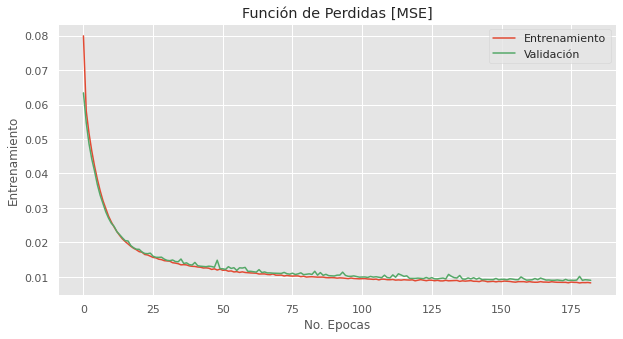

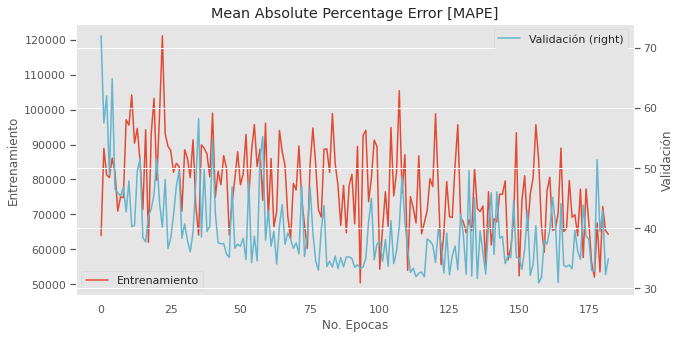

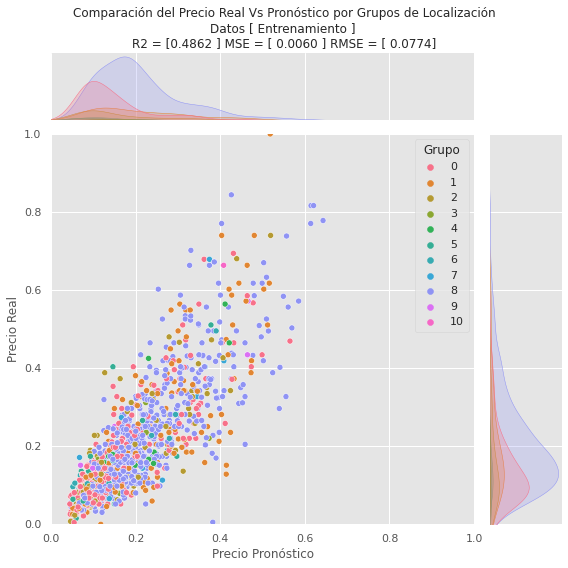

No handles with labels found to put in legend.


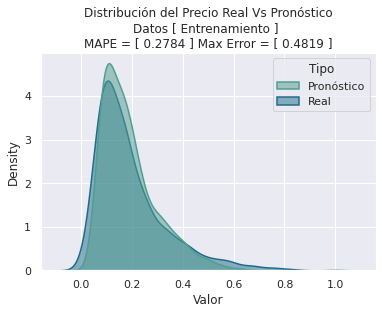

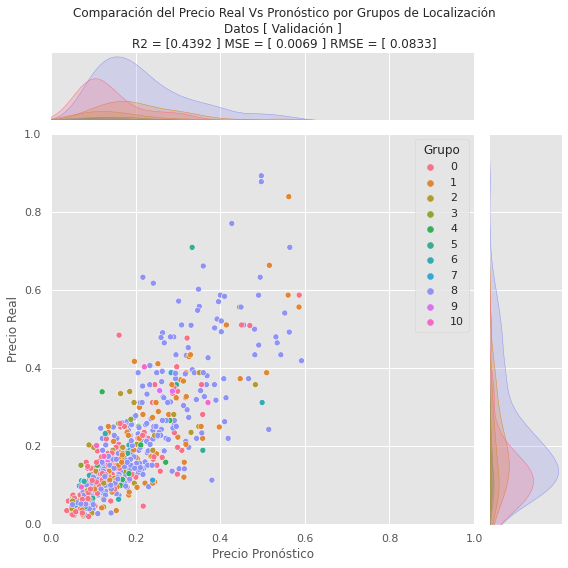

No handles with labels found to put in legend.


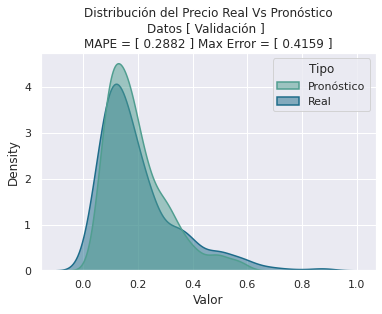

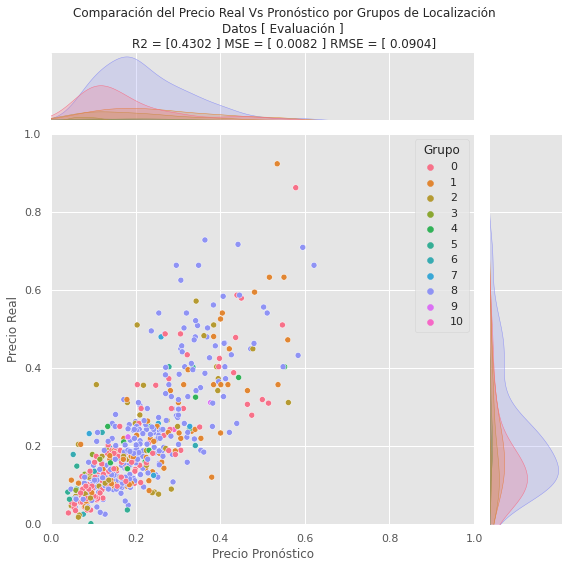

No handles with labels found to put in legend.


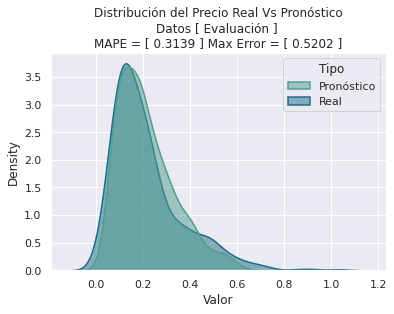

In [ ]:
ModeloCandidatoNo3=RedNeuronal(dred_train.shape[1], int(dred_train.shape[1]/3),  1.6, 'ReLu', 'L2', 0.001, 'RMSprop', 0.001, 1000, 64)
ModeloCandidatoNo3.Crea_RN()
ModeloCandidatoNo3.Entrenamiento(FOLDER_EXP, dred_train, dy_train, dred_val, dy_val)

# grafica el modelo de la red neuronal
ModeloCandidatoNo3.model.save(FOLDER_EXP+"Modelo.h5") 
dot_img_file = FOLDER_EXP+'modeloRedNeuronal.png'
tf.keras.utils.plot_model(ModeloCandidatoNo3.model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)
# graficas del entrenamiento
GraficasEntrenamiento(ModeloCandidatoNo3.hist, 'loss', FOLDER_EXP)
GraficasEntrenamiento(ModeloCandidatoNo3.hist, 'MAPE', FOLDER_EXP)

# Evaluacion del modelo con datos de ENTRENAMIENTO
ModeloCandidatoNo3.EvaluacionEntrenamiento(dred_train, dy_train)
y_grupo= pd.DataFrame(dcuant_train.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_train = ModeloCandidatoNo3.df_datos
df_train['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Entrenamiento', df_train, ModeloCandidatoNo3.r2, ModeloCandidatoNo3.mse, ModeloCandidatoNo3.rmse)
df_datos = ModeloCandidatoNo3.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Entrenamiento', df,  ModeloCandidatoNo3.mape, ModeloCandidatoNo3.maxe)
if NoExperimento==50:
  data = {'Metrica': ['Entrenamiento'],
          'Experimento': [NoExperimento],
          'RMSE': [ModeloCandidatoNo3.rmse],
          'R2': [ModeloCandidatoNo3.r2],
          'MAPE': [ ModeloCandidatoNo3.mape],
          'MAX ERR': [ ModeloCandidatoNo3.maxe]
          }
  df_metricas = pd.DataFrame(data)
else:
  new_row = {'Metrica':'Entrenamiento', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo3.mse, 'R2':ModeloCandidatoNo3.r2, 'MAPE':ModeloCandidatoNo3.mape, 'MAX ERR':ModeloCandidatoNo3.maxe}
  #append row to the dataframe
  df_metricas = df_metricas.append(new_row, ignore_index=True)

# Evaluacion del modelo con datos de VALIDACION
ModeloCandidatoNo3.EvaluacionEntrenamiento(dred_val, dy_val)
y_grupo= pd.DataFrame(dcuant_val.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_val = ModeloCandidatoNo3.df_datos
df_val['Grupo'] = y_grupo
GraficasRealvsPredict(FOLDER_EXP, 'Validación', df_val, ModeloCandidatoNo3.r2, ModeloCandidatoNo3.mse, ModeloCandidatoNo3.rmse)
df_datos = ModeloCandidatoNo3.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Validación', df,  ModeloCandidatoNo3.mape, ModeloCandidatoNo3.maxe)
new_row = {'Metrica':'Validación', 'Experimento':NoExperimento, 'RMSE':ModeloCandidatoNo3.mse, 'R2':ModeloCandidatoNo3.r2, 'MAPE':ModeloCandidatoNo3.mape, 'MAX ERR':ModeloCandidatoNo3.maxe}
#append row to the dataframe
df_metricas = df_metricas.append(new_row, ignore_index=True)

# Evaluacion del modelo con datos de ENTRENAMIENTO

ModeloCandidatoNo3.EvaluacionEntrenamiento(dred_test, dy_test)
y_grupo= pd.DataFrame(dcuant_test.iloc[:, 17:])
y_grupo.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_grupo = y_grupo.idxmax(axis="columns")
df_test = ModeloCandidatoNo3.df_datos
df_test['Grupo'] = y_grupo

GraficasRealvsPredict(FOLDER_EXP, 'Evaluación', df_test, ModeloCandidatoNo3.r2, ModeloCandidatoNo3.mse, ModeloCandidatoNo3.rmse)
df_datos = ModeloCandidatoNo3.df_datos
df_datos = df_datos.reset_index()
a = pd.Series(df_datos["index"])
b = pd.Series(df_datos["Pronóstico"])
c = pd.Series(df_datos["Reales"])
d = pd.Series(df_datos["Grupo"])
frame1 = { 'Tipo': 'Pronóstico',  'Propiedad': a, 'Valor': b, 'Grupo' : d}
df1 = pd.DataFrame(frame1)
frame2 = { 'Tipo': 'Real',  'Propiedad': a, 'Valor': c, 'Grupo' : d}
df2 = pd.DataFrame(frame2)
df = pd.concat([df1, df2], ignore_index=True)
GraficasKDE_RealvsPredict(FOLDER_EXP, 'Evaluación', df,  ModeloCandidatoNo3.mape, ModeloCandidatoNo3.maxe)

In [ ]:


def GraficasMetricasE(path, titulo, exp, df_metricas):
  plt.style.use("ggplot")
  sns.set_theme(style="ticks")
  g = sns.relplot(
    data=df_metricas,
    x="Modelo", y="Valor",
    hue="Metrica",  style = "Metrica",
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False), dashes=True, markers=True
  )
  g.fig.subplots_adjust(top=0.9)
  g.fig.suptitle(titulo)
  g.set(ylim=(-1, 1))
  plt.axis(True)
  fig1 = plt.gcf()
  plt.savefig(path+"Metricas_"+exp+".jpg", bbox_inches='tight')
  plt.show()


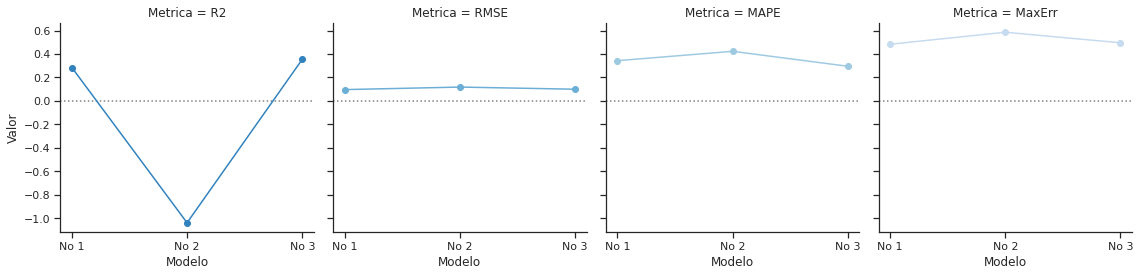

In [ ]:
grid = sns.FacetGrid(df10, col="Metrica", hue="Metrica", palette="tab20c",
                     col_wrap=4, height=4)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "Modelo", "Valor", marker="o")



# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

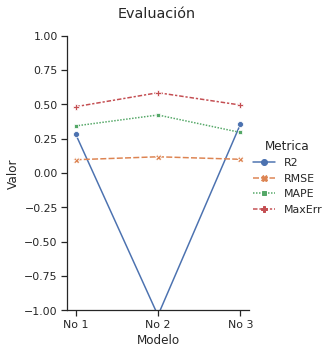

In [ ]:
GraficasMetricasE(FOLDER_EXP, 'Evaluación','e' , df10)

In [ ]:
d = {
    "Modelo": pd.Series(['No 1', 'No 1', 'No 1', 'No 1',
                        'No 2', 'No 2', 'No 2', 'No 2',
                        'No 3', 'No 3', 'No 3', 'No 3'
                        ]),
    "Metrica": pd.Series(['R2', "RMSE", "MAPE", "MaxErr",
                          'R2', "RMSE", "MAPE", "MaxErr", 
                          'R2', "RMSE", "MAPE", "MaxErr"
                          ]),
    "Valor": pd.Series([
                         0.2849, 0.0968, 0.3431, 0.4831,
                        -1.0370, 0.1184, 0.4229, 0.5852,
                        0.3545, 0.1001, 0.2956, 0.4954]),
}

df10 = pd.DataFrame(d)
df10

,Modelo,Metrica,Valor
0,No 1,R2,0.2849
1,No 1,RMSE,0.0968
2,No 1,MAPE,0.3431
3,No 1,MaxErr,0.4831
4,No 2,R2,-1.0370
5,No 2,RMSE,0.1184
6,No 2,MAPE,0.4229
7,No 2,MaxErr,0.5852
8,No 3,R2,0.3545
9,No 3,RMSE,0.1001


# Identificar las propiedades rentables

In [ ]:
umbral = 0.0

df_datos = ModeloCandidatoNo3.df_datos
df_datos["Rentable"] = np.where(df_datos["Reales"]< (df_datos["Pronóstico"] * (1 + umbral) ), True, False)
df_datos["Diferencia"] = np.where(df_datos["Reales"]< (df_datos["Pronóstico"] * (1 + umbral) ), df_datos["Pronóstico"] - df_datos["Reales"], 0)
df_datos["Tipo"] = 0
df_datos["Tipo"] = np.where(df_datos["Diferencia"]< 0.08, 1, df_datos["Tipo"])
df_datos["Tipo"] = np.where((df_datos["Diferencia"]> 0.08) & (df_datos["Diferencia"]< 0.2), 2, df_datos["Tipo"])
df_datos["Tipo"] = np.where(df_datos["Diferencia"]> 0.15 , 3, df_datos["Tipo"])
df_datos[(df_datos["Tipo"]==3) & (df_datos["Rentable"])]

,Pronóstico,Reales,Grupo,Rentable,Diferencia,Tipo
27,0.499363,0.319572,0,True,0.179791,3
29,0.560964,0.311927,2,True,0.249037,3
66,0.244385,0.082569,2,True,0.161816,3
77,0.536542,0.357798,1,True,0.178744,3
81,0.379761,0.120795,1,True,0.258966,3
90,0.474469,0.279511,0,True,0.194959,3
135,0.438974,0.258410,8,True,0.180564,3
176,0.239135,0.081040,2,True,0.158095,3
199,0.400659,0.233945,1,True,0.166714,3
234,0.513976,0.310398,0,True,0.203579,3


In [ ]:
# cargar los datos de las propiedades
ruta_users = os.path.join(BASE_FOLDER, "df_limpios_test.csv")
df_limpios_test = pd.read_csv(ruta_users, sep=',',  engine='python')

In [ ]:
df_premium = df_limpios_test[(df_datos["Tipo"]==3) & (df_datos["Rentable"])]
df_premium.shape

(19, 16)

In [ ]:
import folium as folium

def GraficarUbicacionGrupo(df):
    center_lat = -0.3163390
    center_lon = -78.46403
    locationmap = folium.Map(location=[ center_lat , center_lon ], zoom_start=7, width=800, height=600 )
    longitud  = len(df)
    colors = [
        'red',    'blue',    'gray',    'darkred',    'lightred',
        'orange',    'beige',    'green',    'darkgreen',    'lightgreen',
        'darkblue',    'lightblue',    'purple',    'darkpurple',    'pink',
        'cadetblue',    'lightgray',    'black'
    ]
    for i in range (longitud):
        lng = float(df.iloc[i]['lng'])
        lat = float(df.iloc[i]['lat'])
        grupo = int(df.iloc[i]['Grupo'])
        description = 'Precio: {:10.2f}'.format(df.iloc[i]['Precio']) + '\nTipo: ' + str(df.iloc[i]['Tipo Propiedad'])+ '\nEstado: ' + str(df.iloc[i]['Estado'])+ '\nA_Construcción: ' + str(df.iloc[i]['Area de Construcción'])+ '\nTerreno mts: ' + str(df.iloc[i]['Terreno mts'])+ '\nDirección: ' + str(df.iloc[i]['Dirección']) 
        CualColor = colors[grupo]


        folium.Marker( [ lat , lng ],
                    popup= description,
                    icon=folium.Icon(color=CualColor)).add_to(locationmap)
    return locationmap

In [ ]:
gr = GraficarUbicacionGrupo(df_premium)
gr